In [2]:
%load_ext autoreload
%autoreload 2
from sklearn.cluster import DBSCAN
import pandas as pd
from sklearn.model_selection import train_test_split

stores_total_train = pd.read_csv("data/stores_train.csv")
stores_test = pd.read_csv("data/stores_test.csv")
stores_extra = pd.read_csv("data/stores_extra.csv")
stores_train, stores_val = train_test_split(stores_total_train, test_size=0.2, random_state=0)

In [3]:
geo_df = stores_total_train.append(stores_extra).append(stores_test)[['lat', 'lon', 'store_id']]


/tmp/ipykernel_18683/2088512738.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  geo_df = stores_total_train.append(stores_extra).append(stores_test)[['lat', 'lon', 'store_id']]


In [4]:
clustering = DBSCAN(eps = 0.2, min_samples=100, metric='haversine').fit(geo_df[['lat', 'lon']])
geo_df['cluster'] = clustering.labels_

In [5]:
geo_df['cluster'].value_counts()

 0    49600
 1      334
-1      186
Name: cluster, dtype: int64

In [6]:
clustering.labels_.max()

1

<AxesSubplot:xlabel='lon', ylabel='lat'>

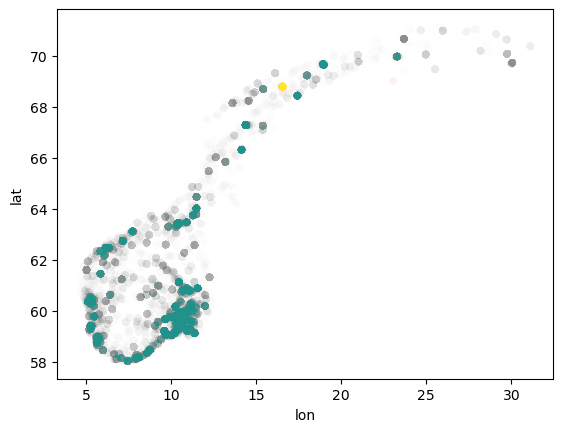

In [7]:
import seaborn as sns
import matplotlib as plt
sns.scatterplot(data=geo_df, x='lon', y="lat", c=clustering.labels_, alpha=0.005)

0.0001 100 10


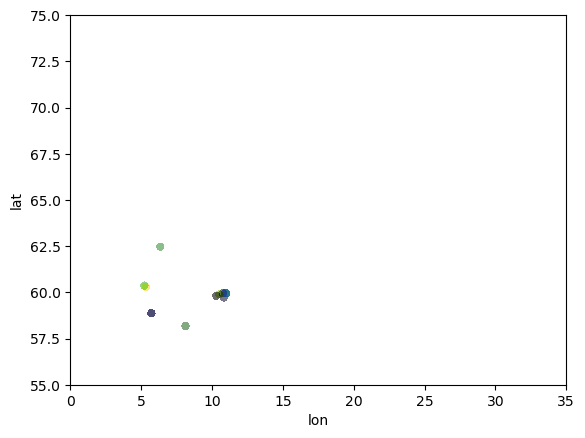

0.0001 125 6


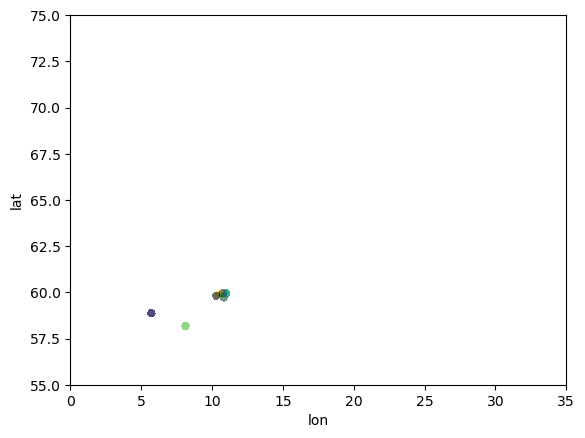

0.0002 100 10


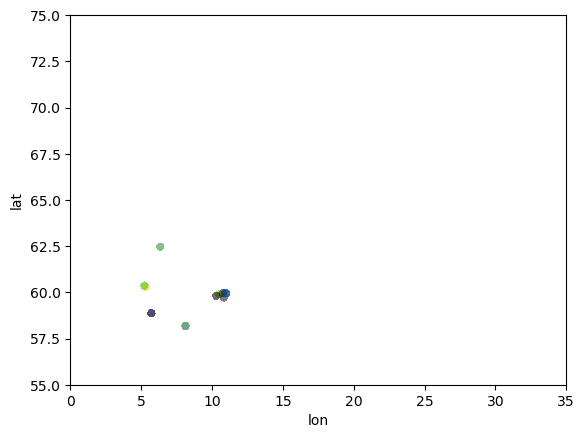

0.0002 125 6


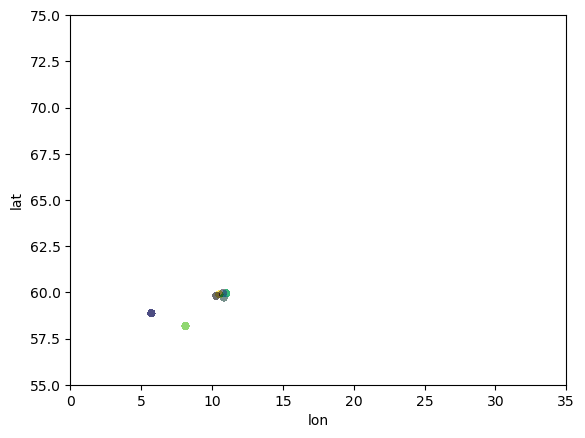

0.0005 100 12


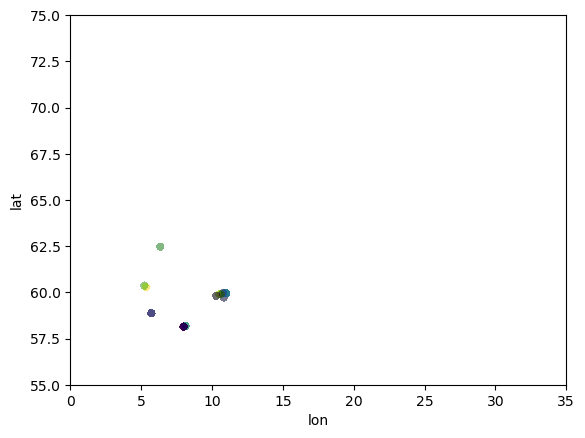

0.0005 125 8


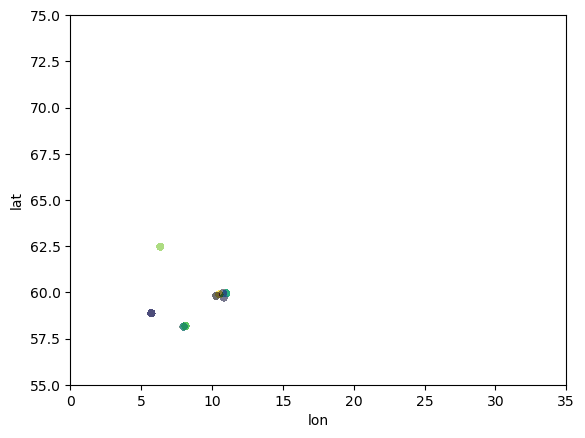

0.0007 100 13


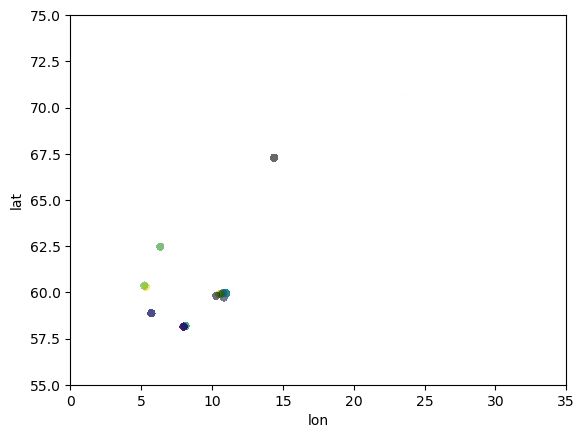

0.0007 125 8


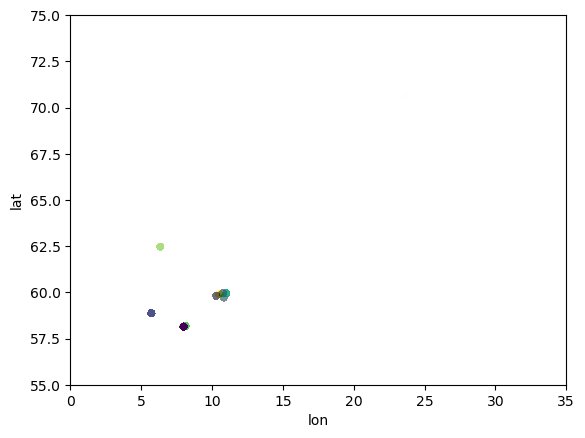

0.001 100 23


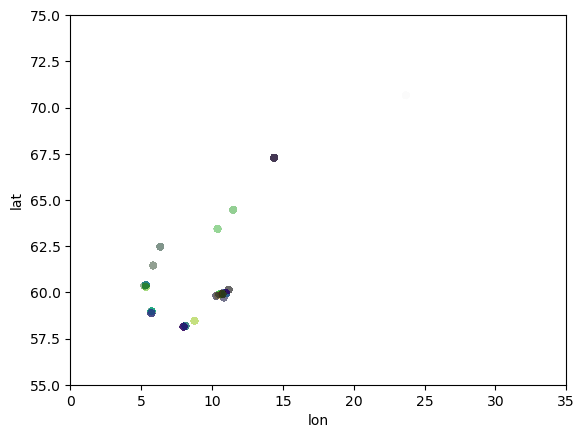

0.001 125 12


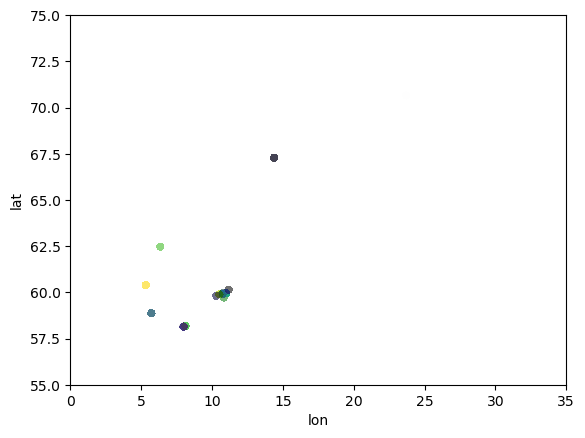

0.001 150 6


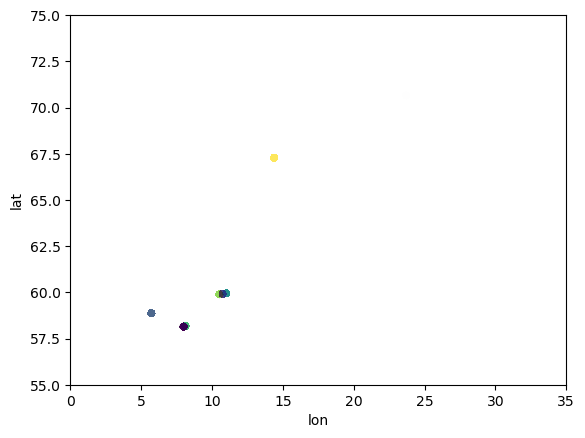

0.002 150 19


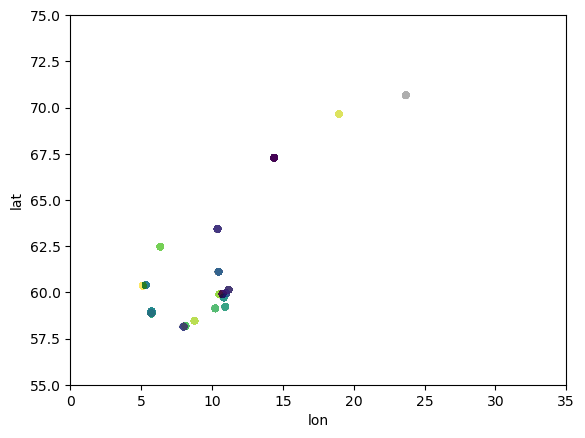

0.002 175 15


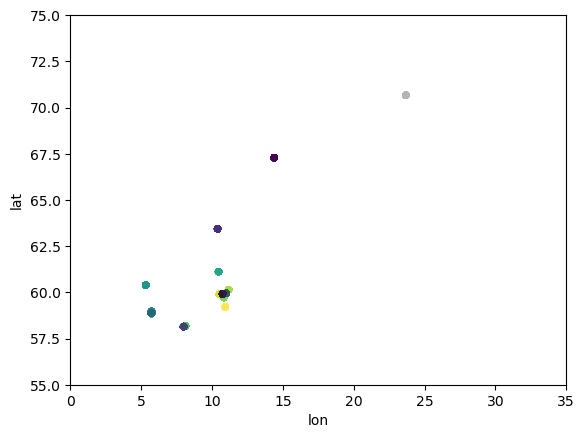

0.002 200 9


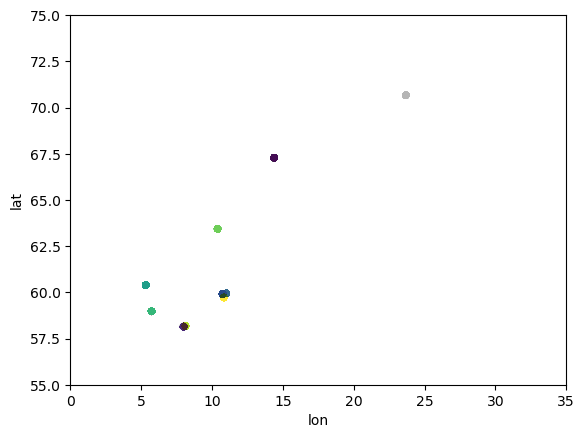

0.002 225 6


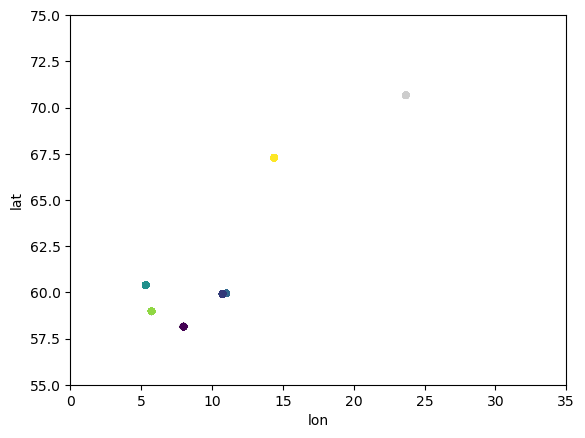

In [8]:
good = []
import matplotlib.pyplot as plt
for eps in [0.0001, 0.0002, 0.0005, 0.0007, 0.001, 0.002]:
    for min_samples in [10, 50, 100, 125, 150, 175, 200, 225, 250, 325, 450]:
        clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='haversine').fit(geo_df[['lat', 'lon']])
        if clustering.labels_.max() > 5 and clustering.labels_.max() < 30:
            good.append((clustering.labels_, eps, min_samples))
            print(eps, min_samples, clustering.labels_.max())
            geo_df['cluster'] = clustering.labels_
            # sns.scatterplot(data=geo_df, x='lon', y="lat", c=clustering.labels_, size='cluster', sizes=(10,500), alpha=0.3)
            sns.scatterplot(data=geo_df[geo_df['cluster']!=-1], x='lon', y="lat", c=geo_df[geo_df['cluster']!=-1]['cluster'], alpha=0.005)
            plt.xlim(0,35)
            plt.ylim(55,75)
            plt.show()


0.0001 100 10


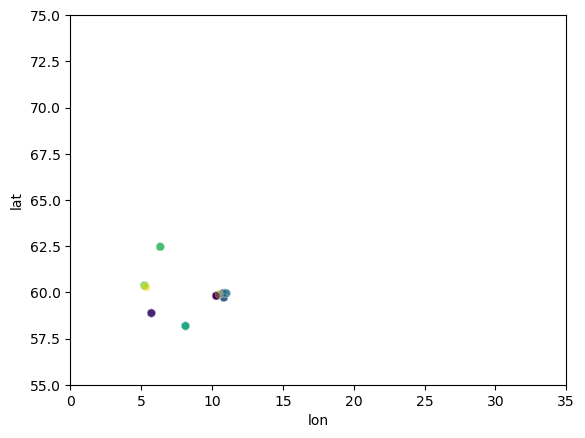

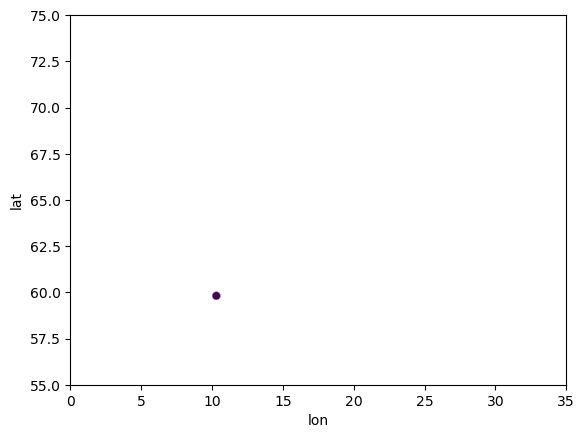

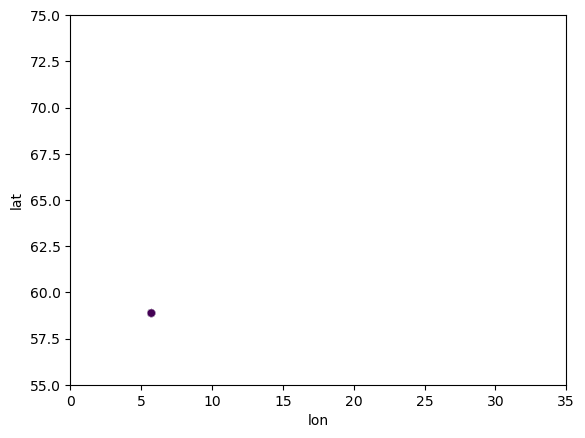

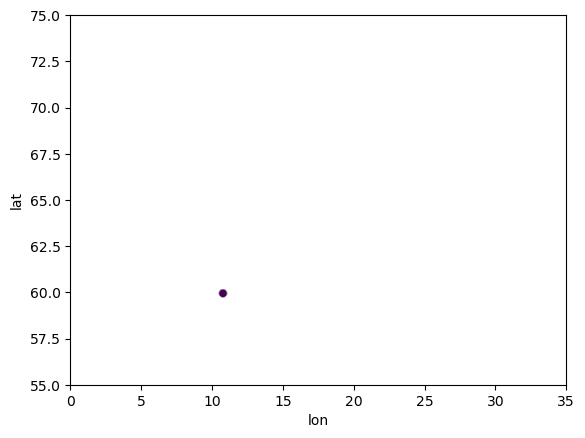

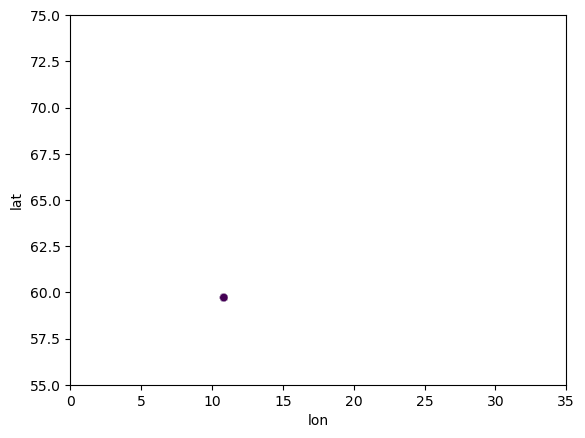

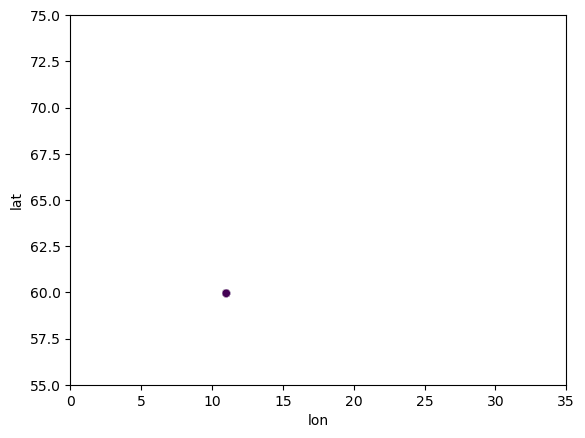

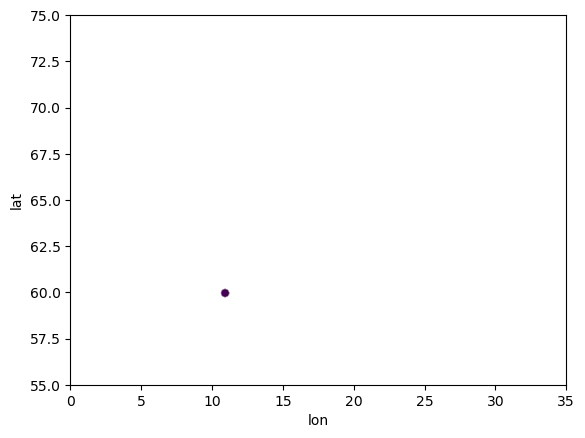

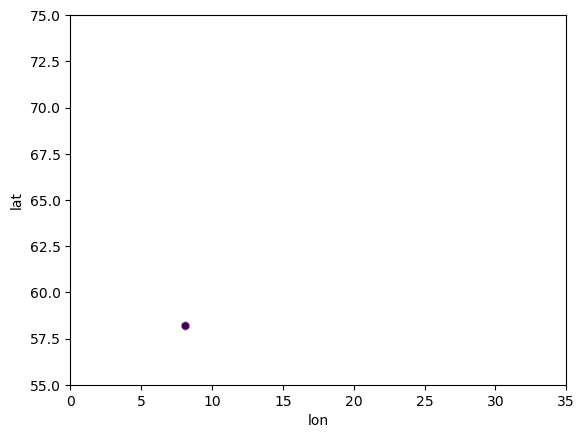

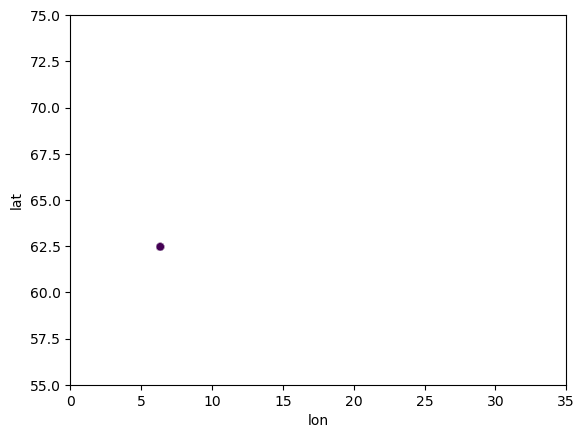

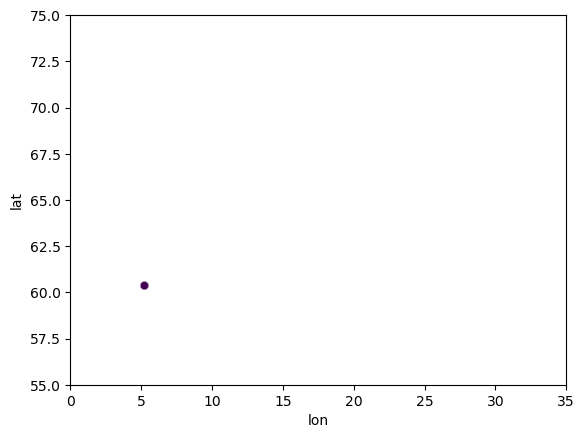

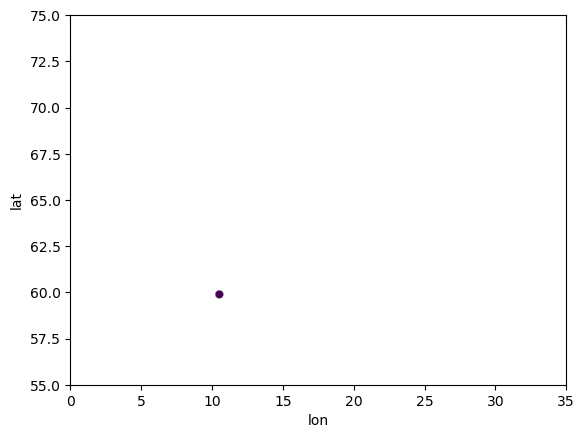

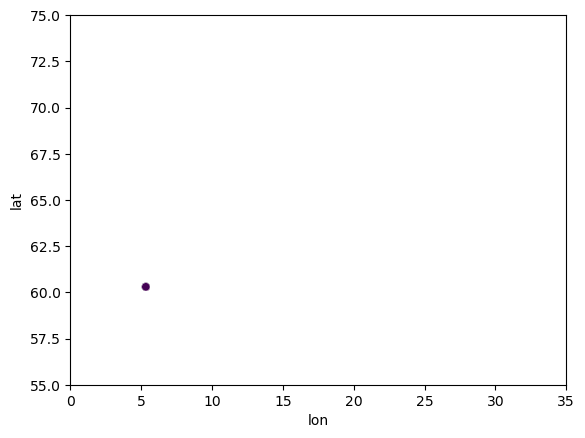

0.0001 125 6


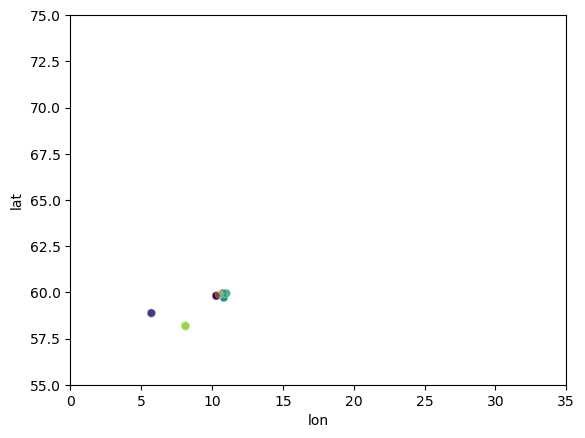

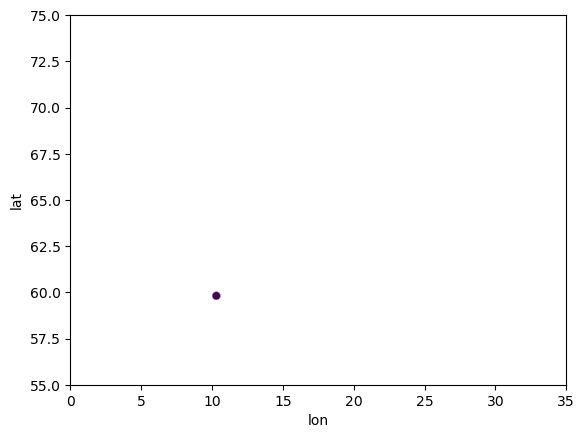

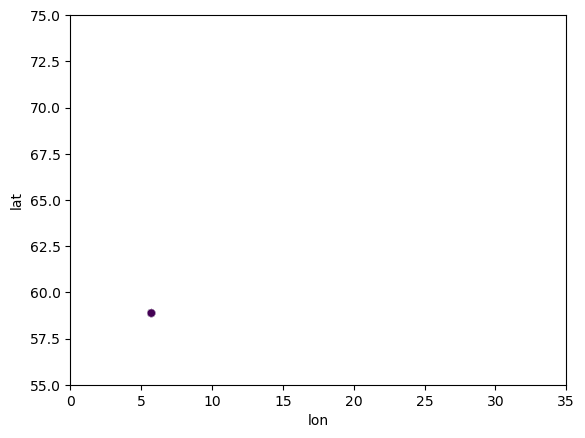

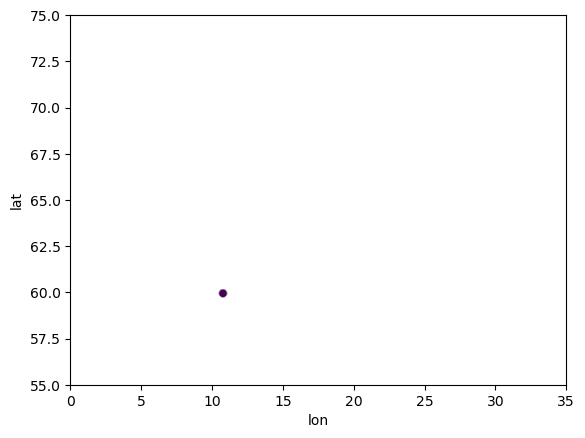

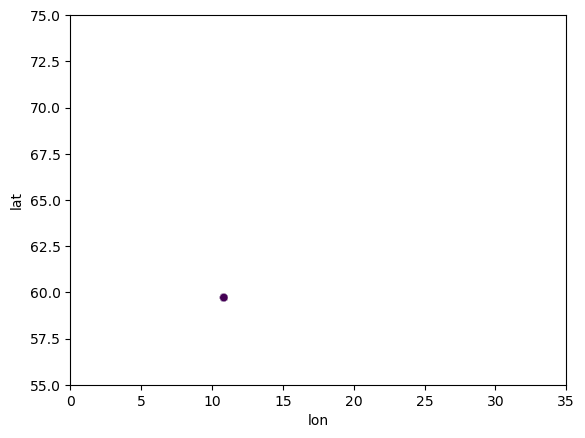

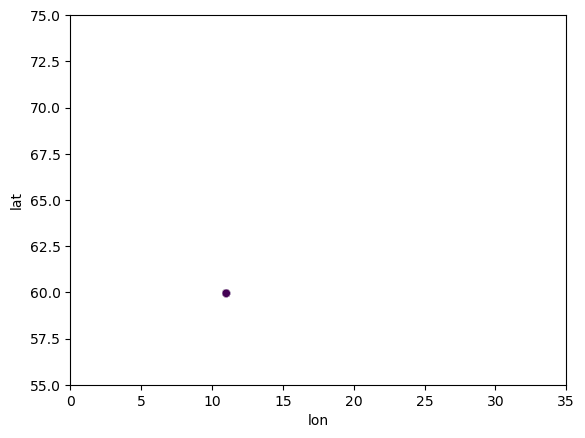

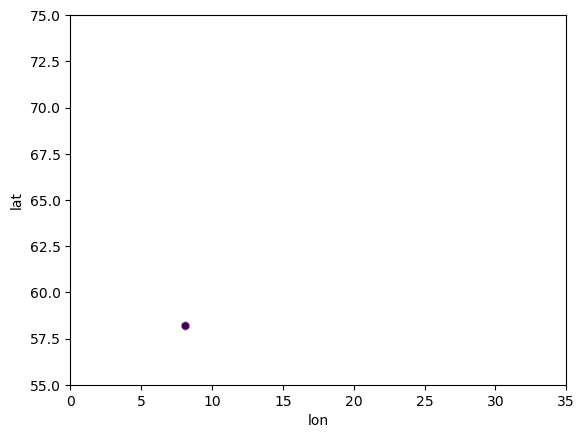

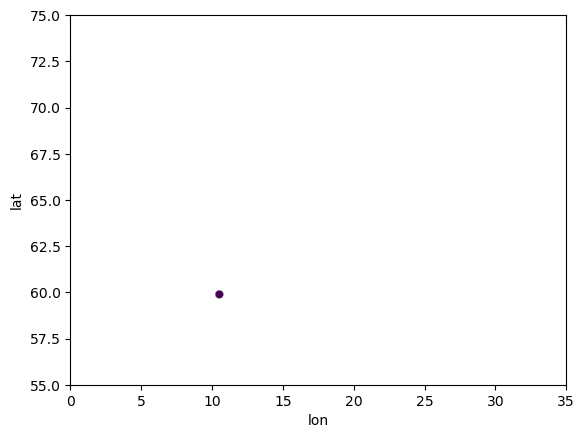

0.0002 100 10


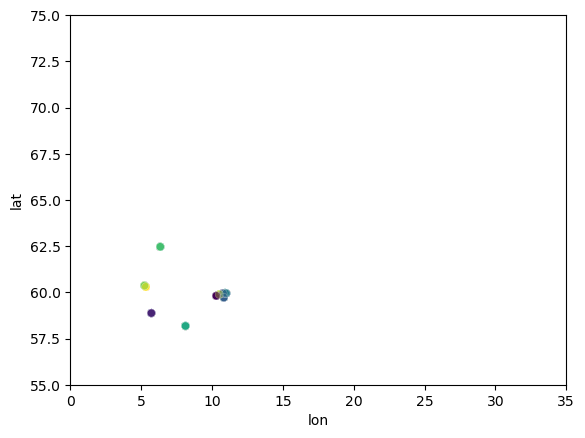

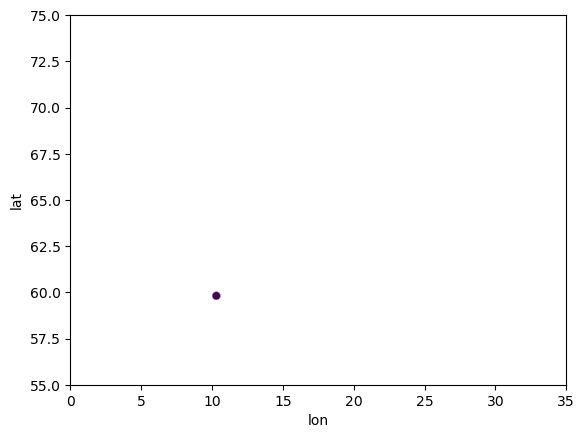

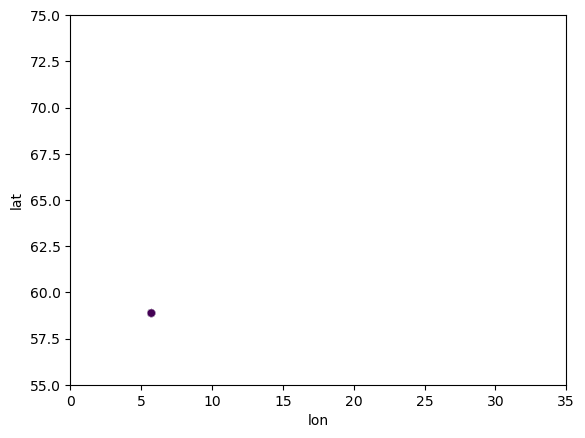

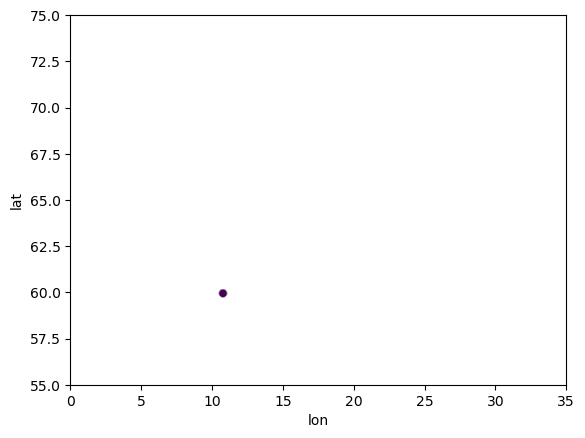

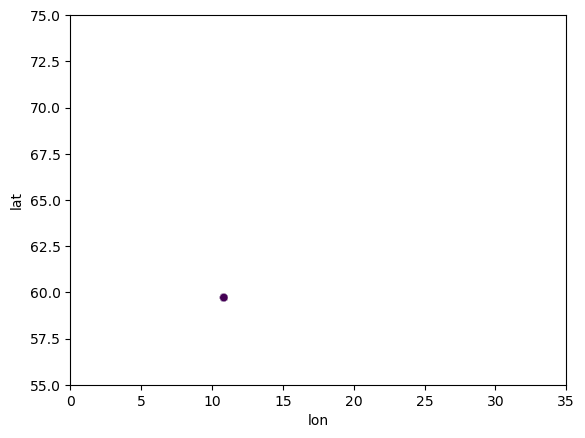

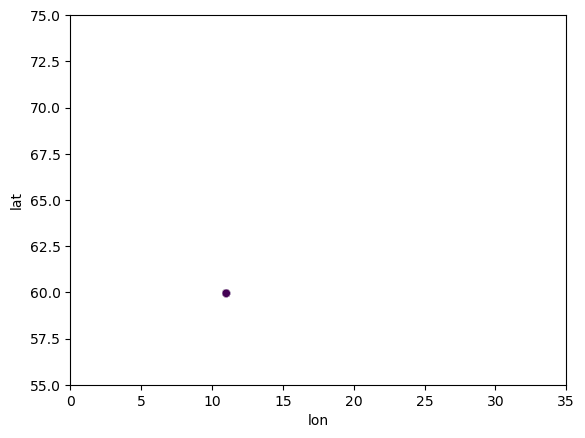

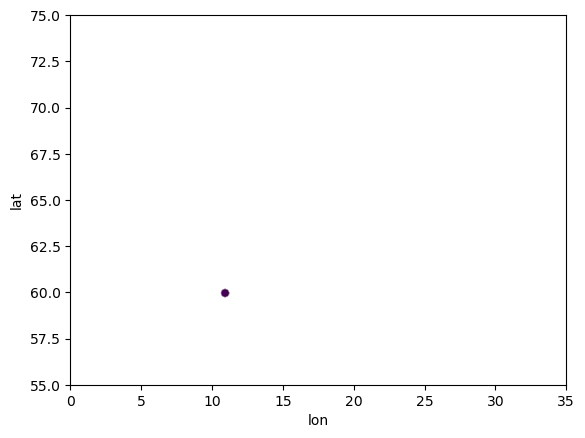

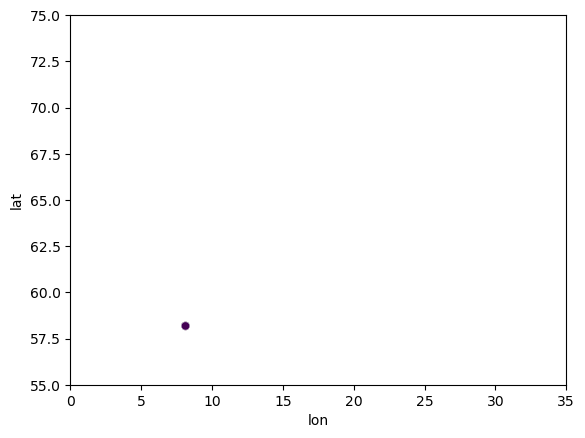

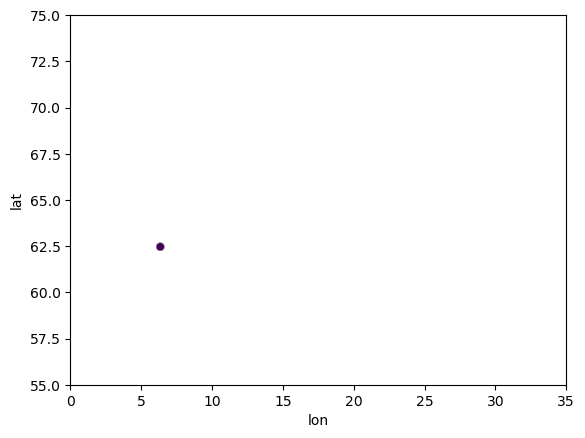

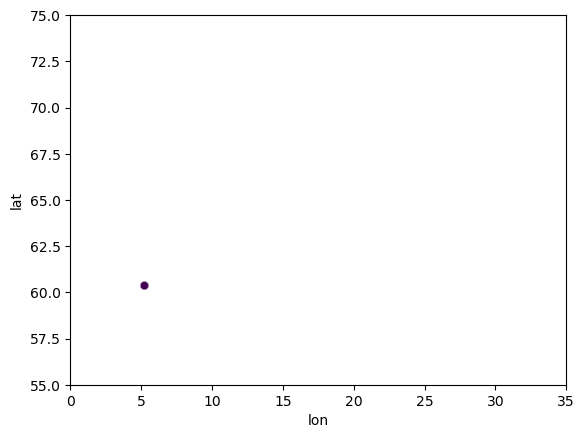

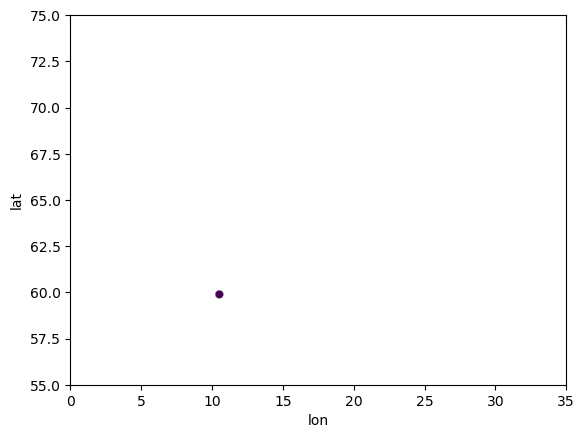

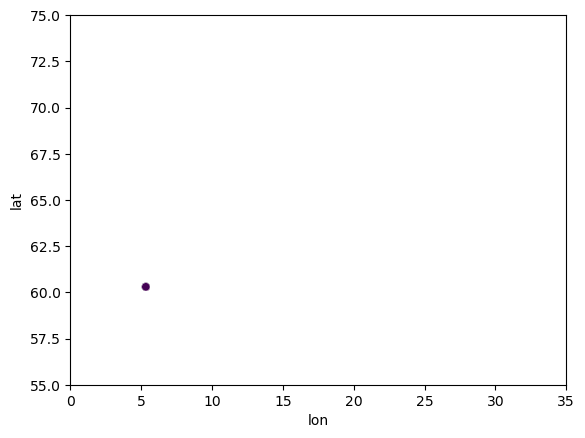

0.0002 125 6


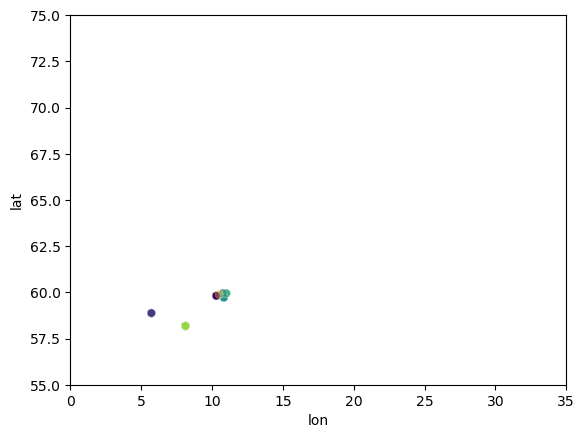

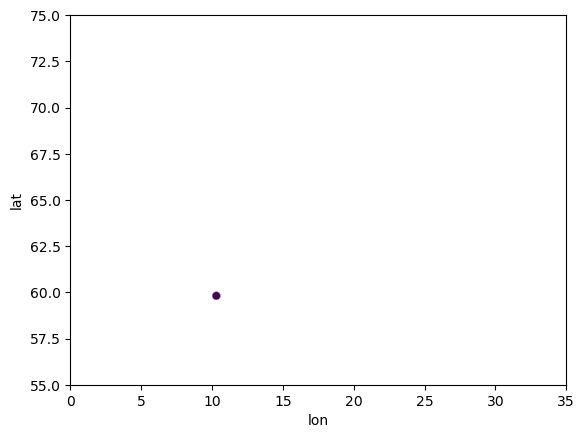

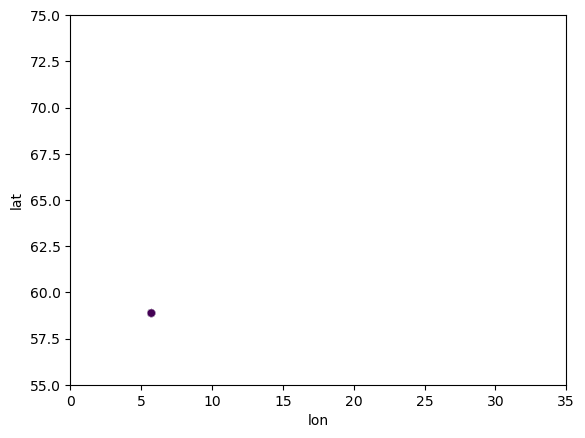

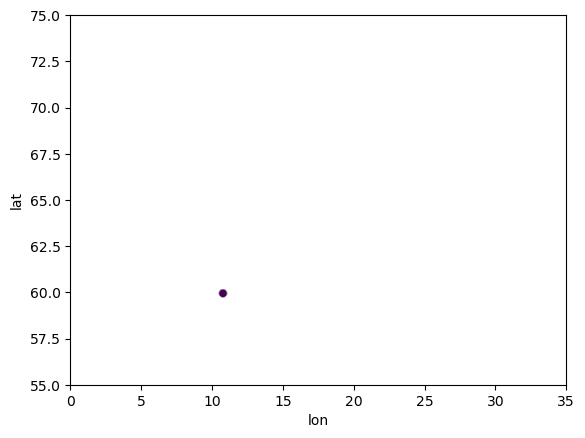

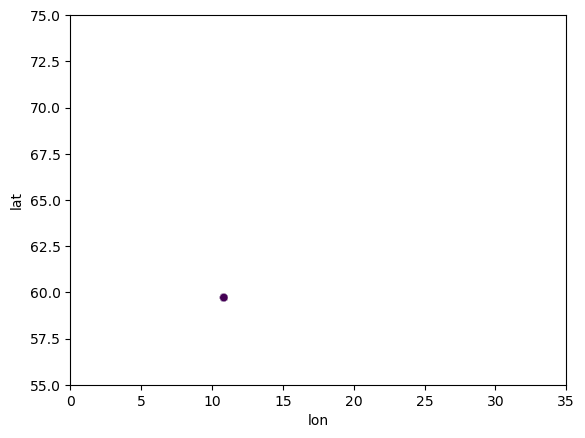

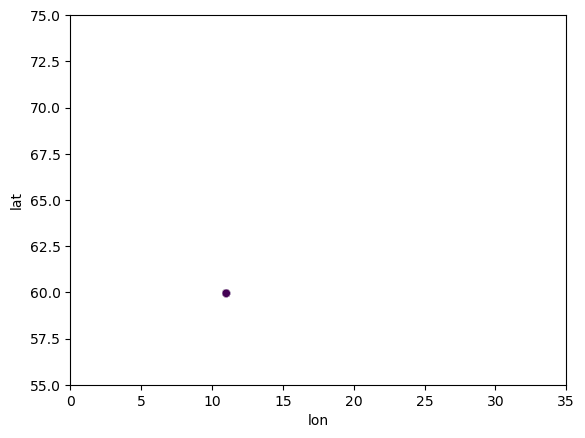

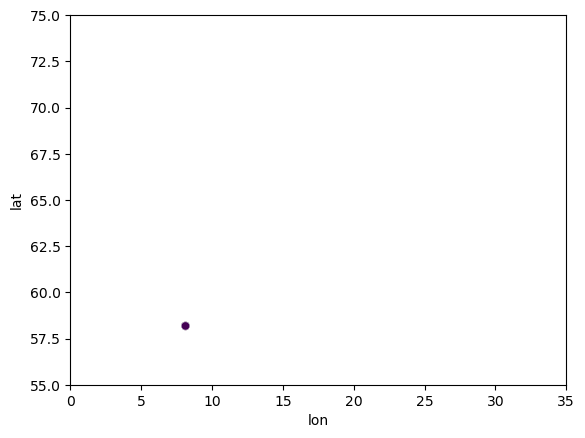

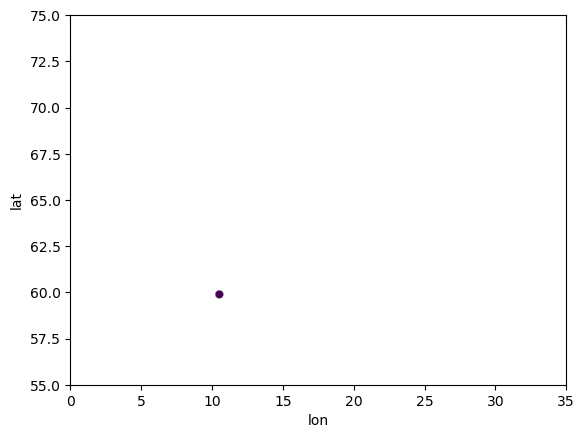

0.0005 100 12


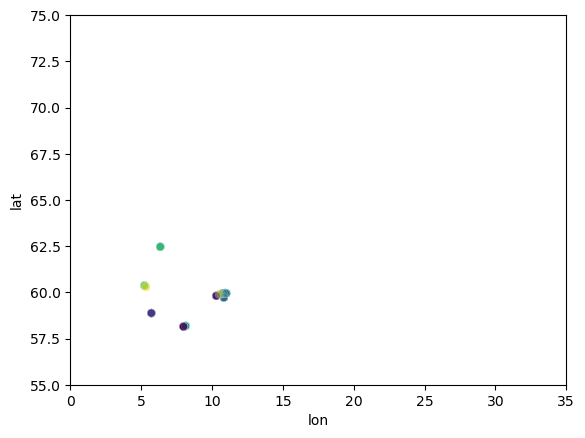

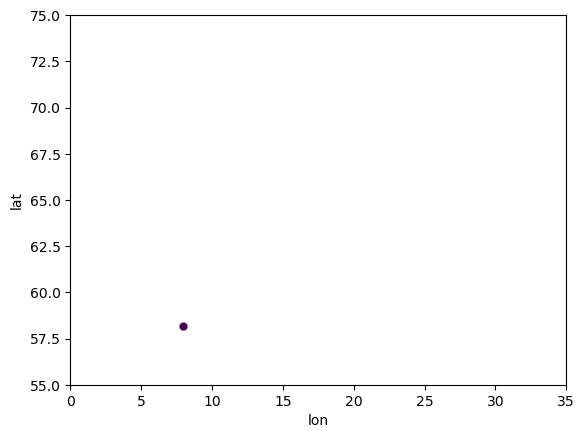

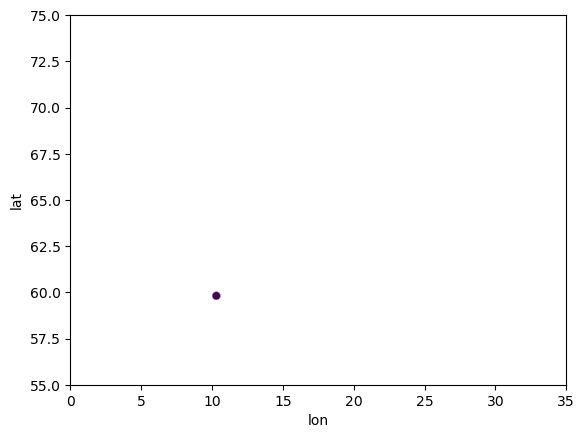

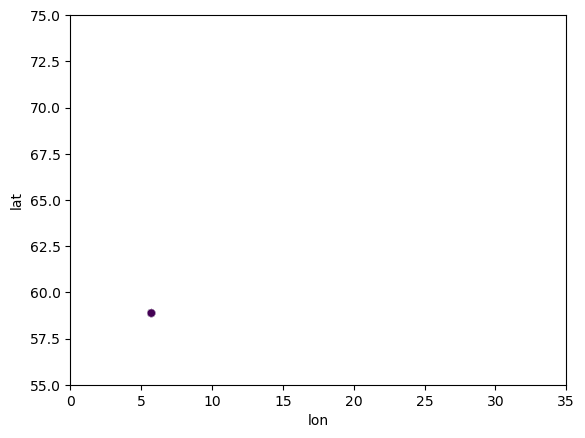

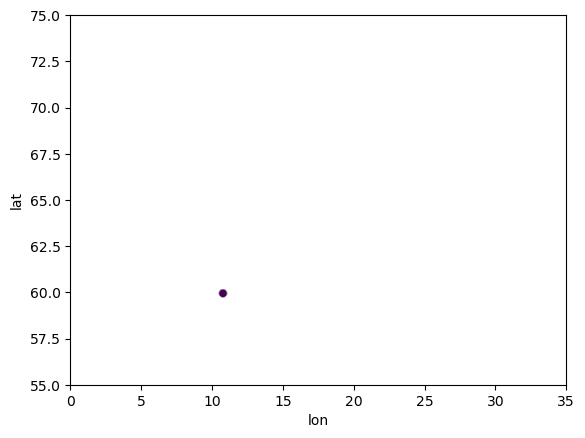

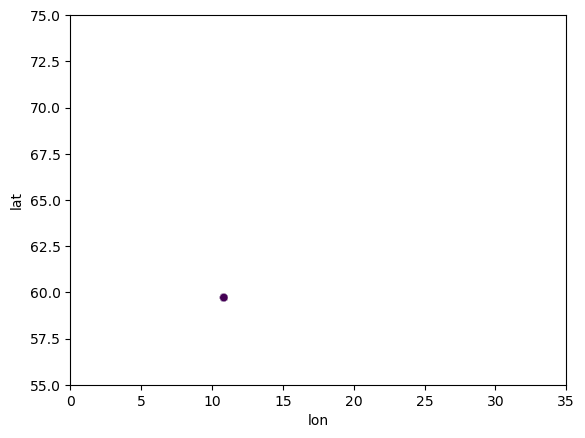

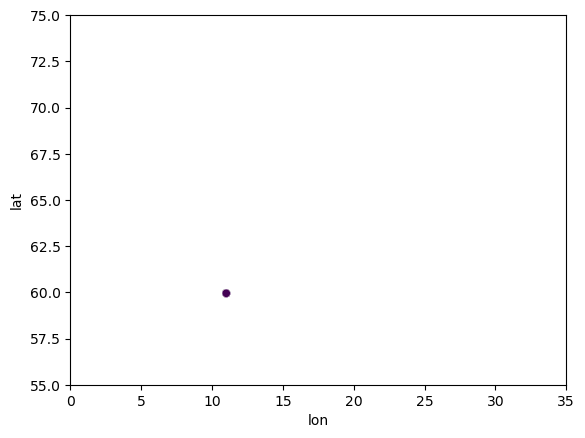

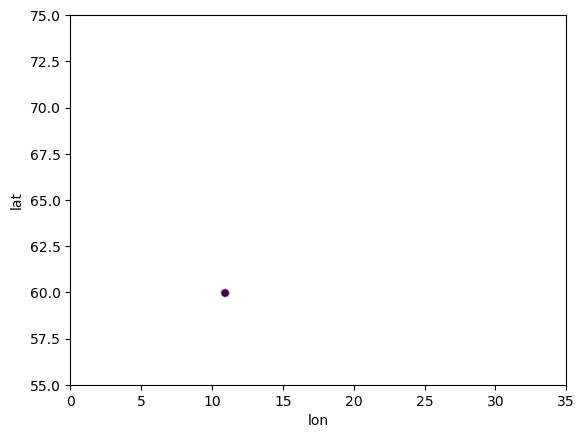

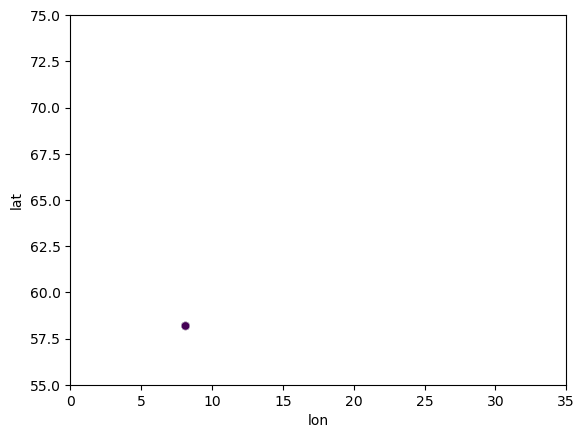

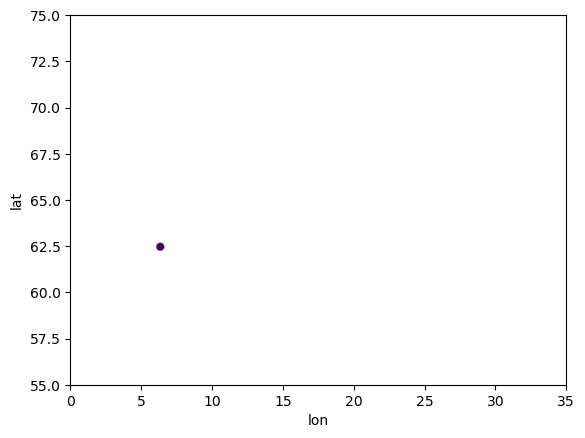

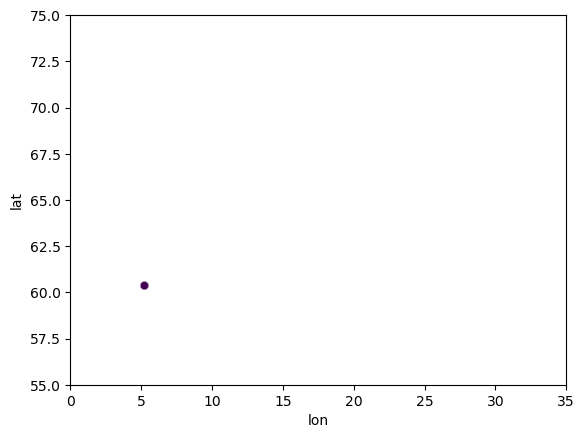

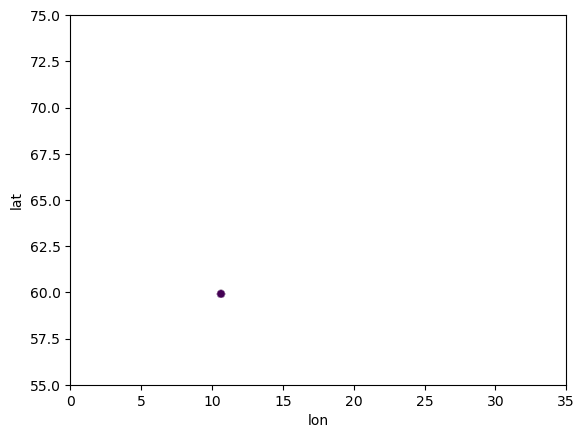

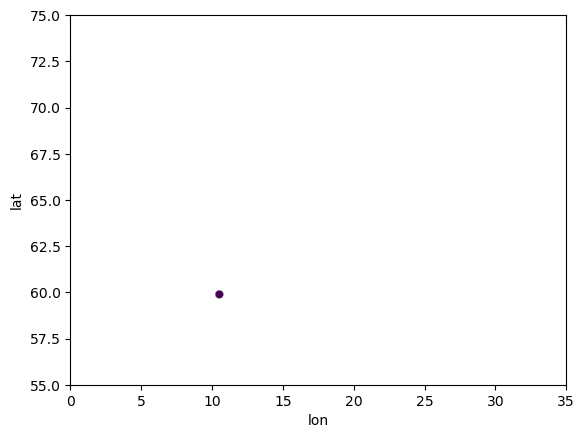

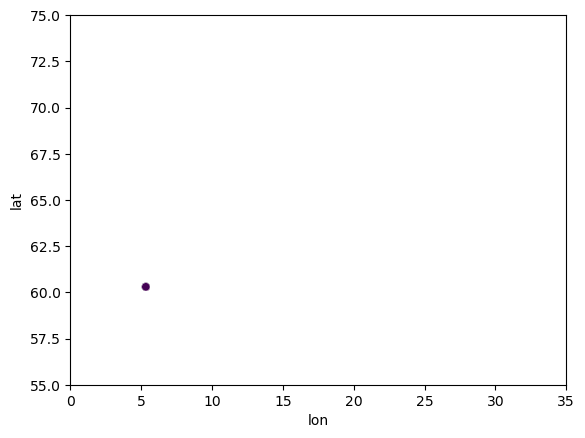

0.0005 125 8


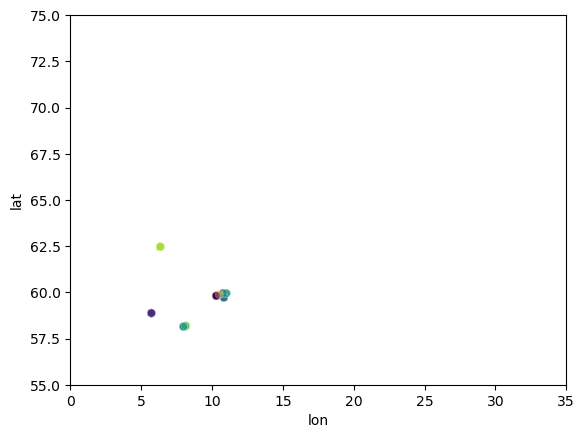

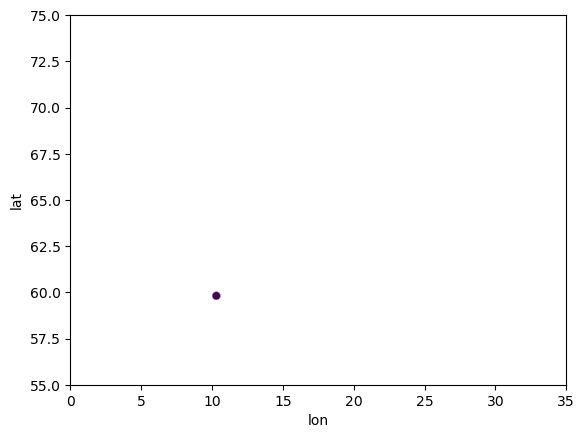

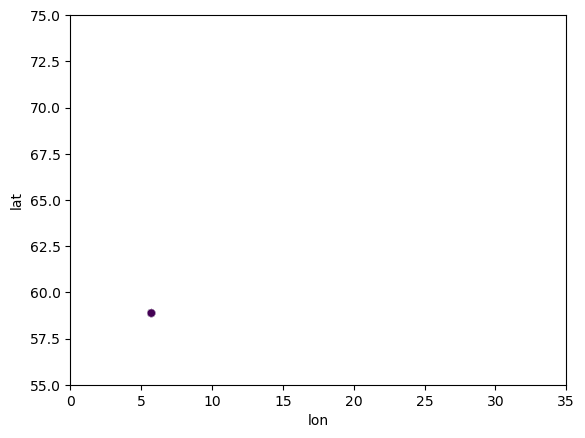

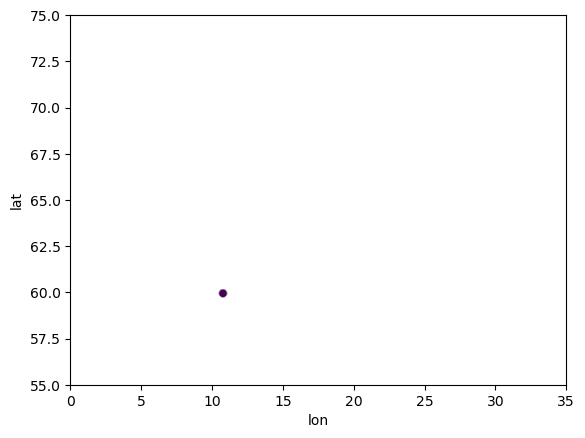

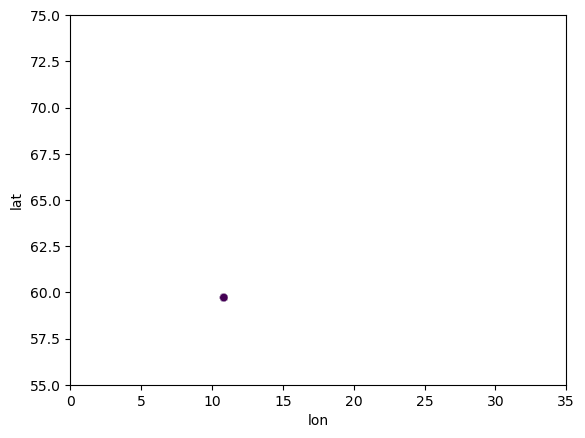

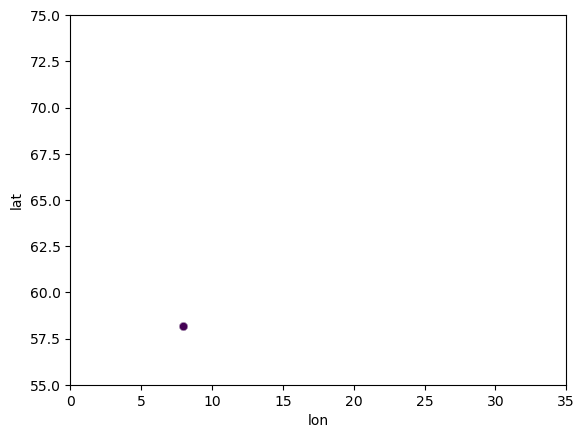

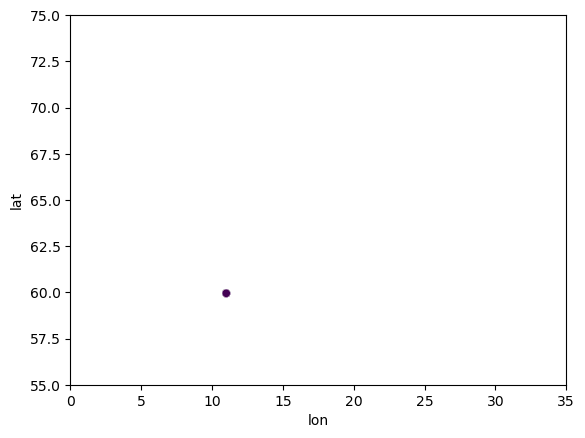

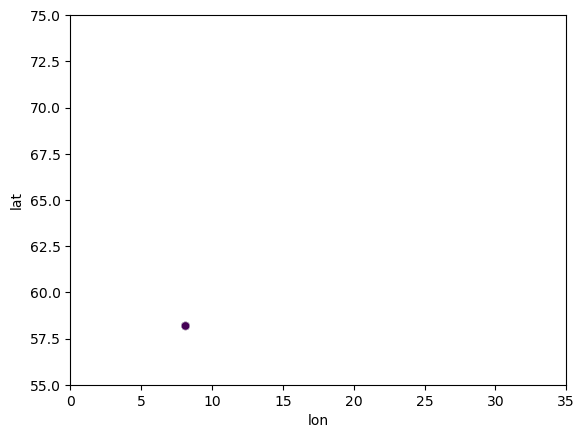

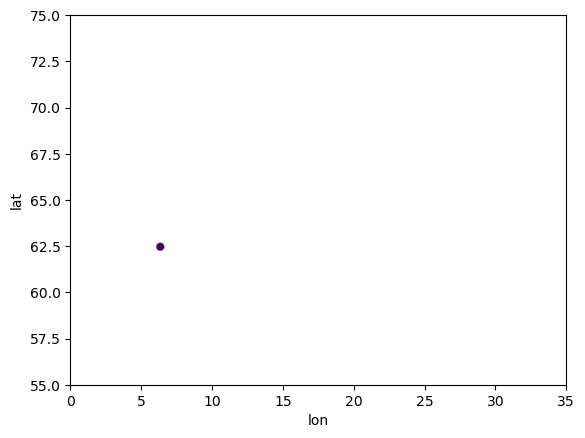

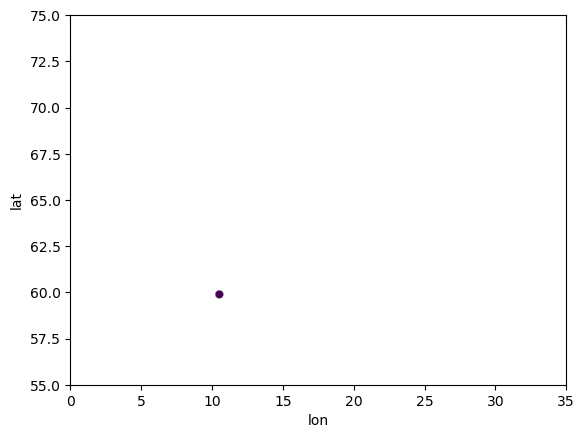

0.0007 100 13


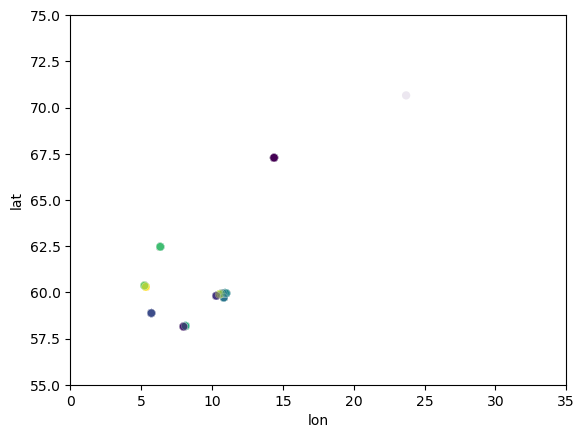

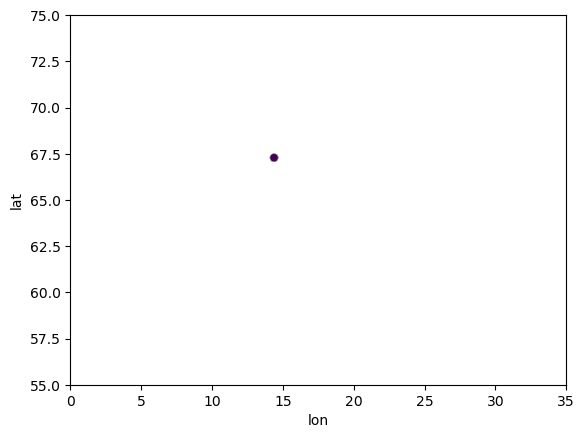

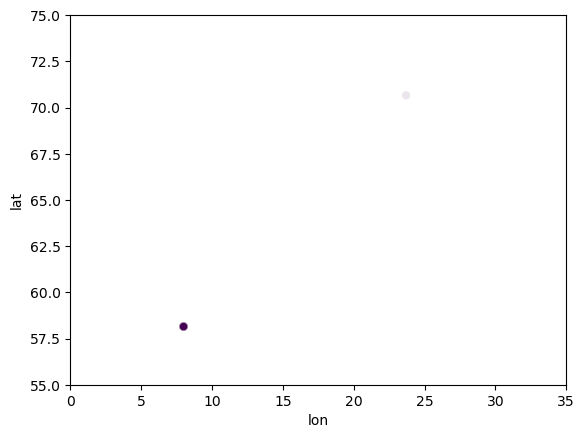

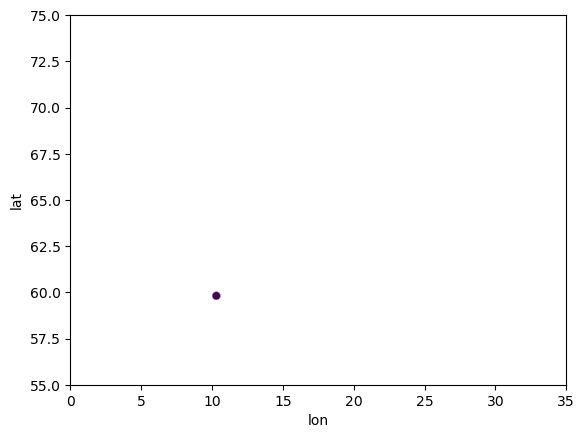

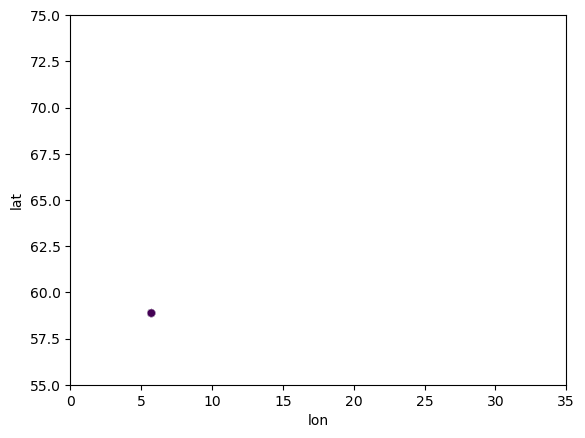

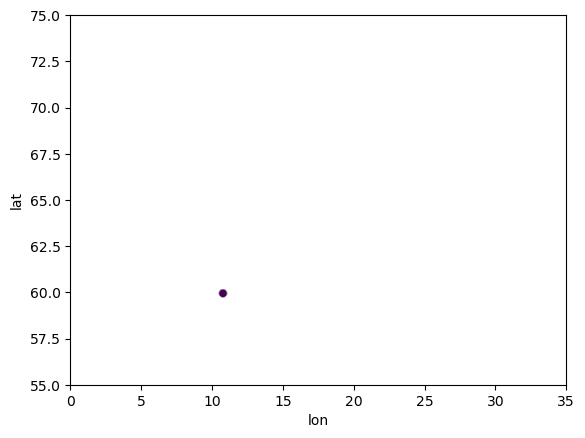

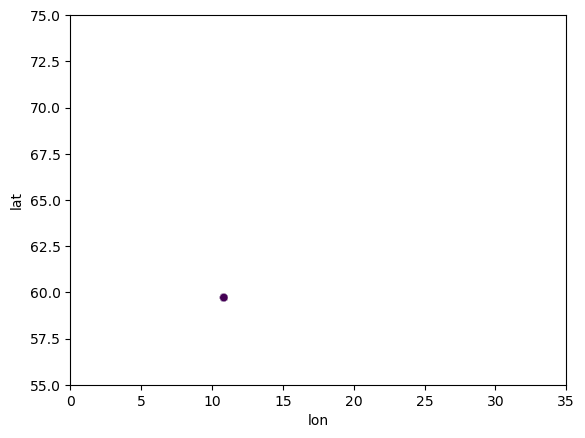

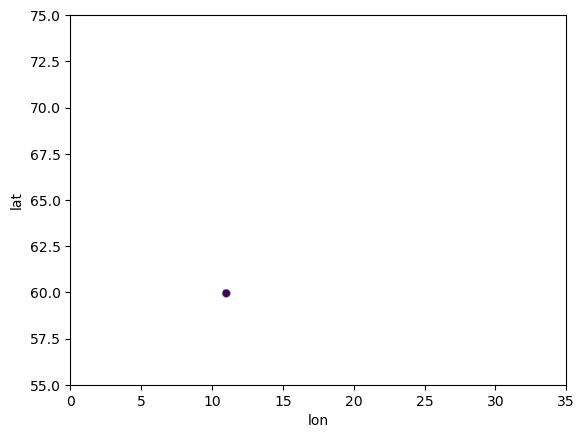

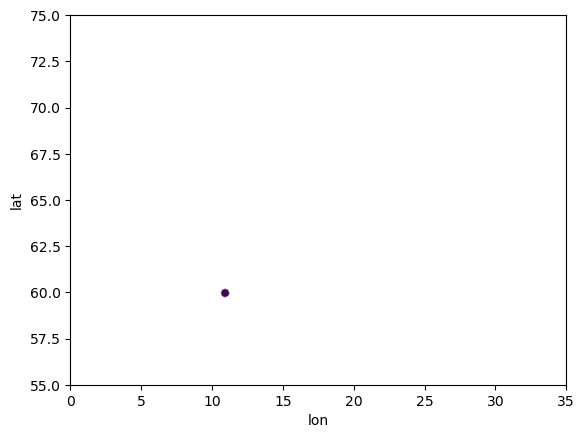

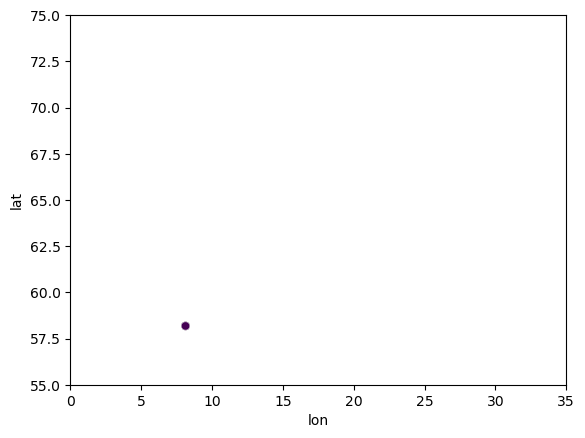

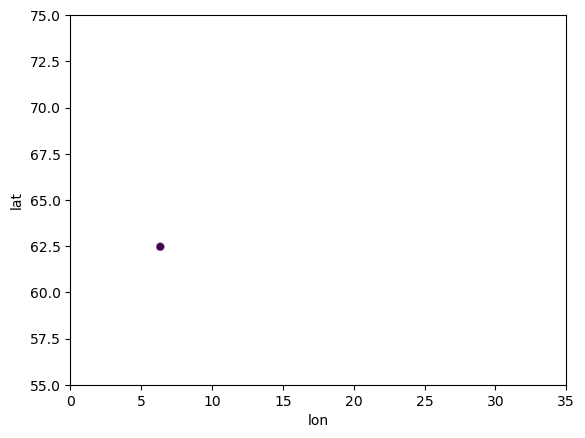

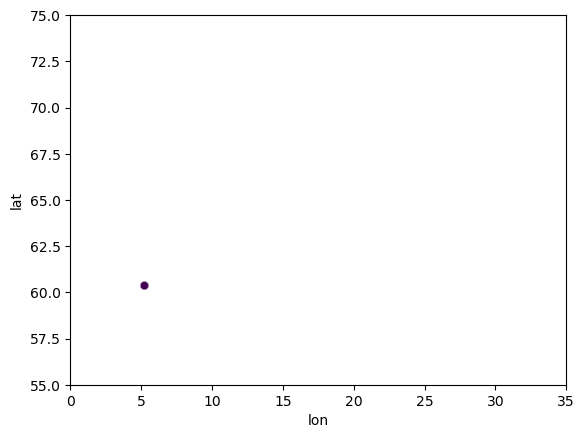

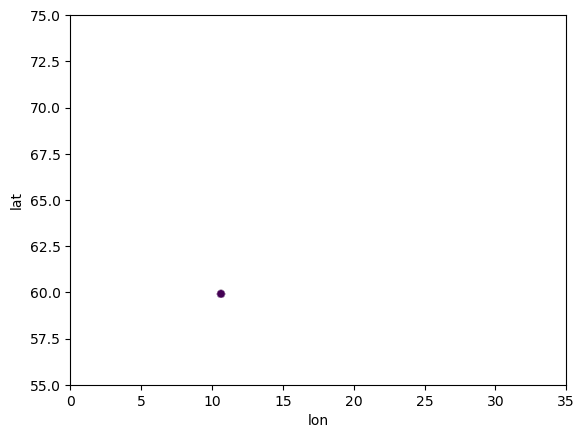

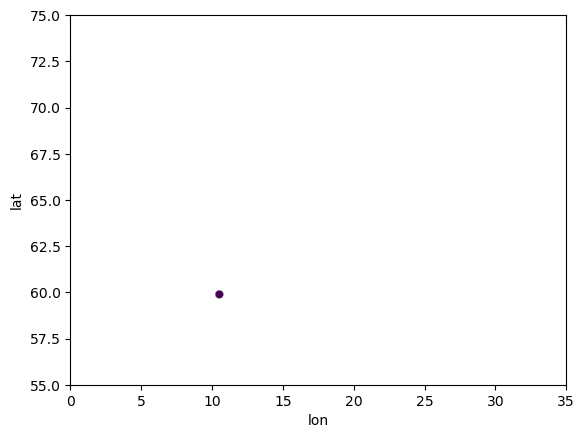

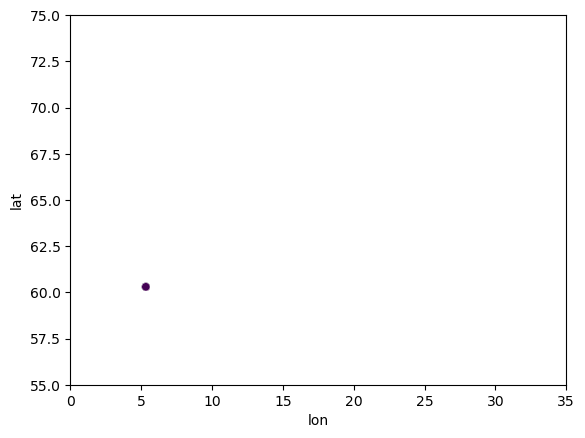

0.0007 125 8


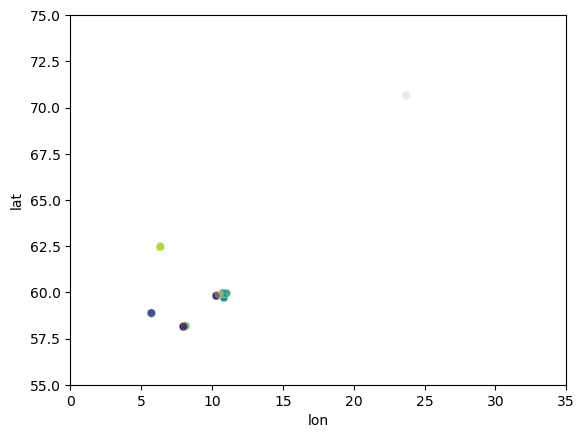

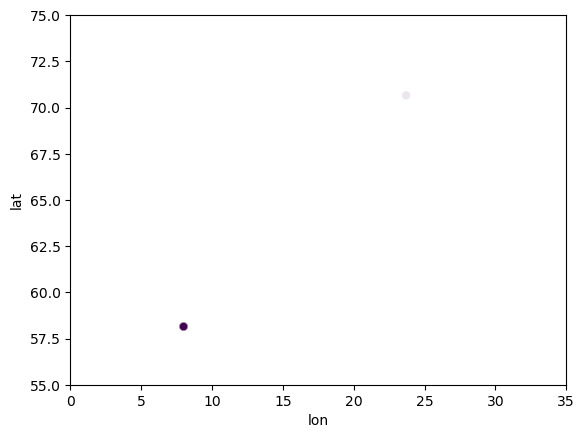

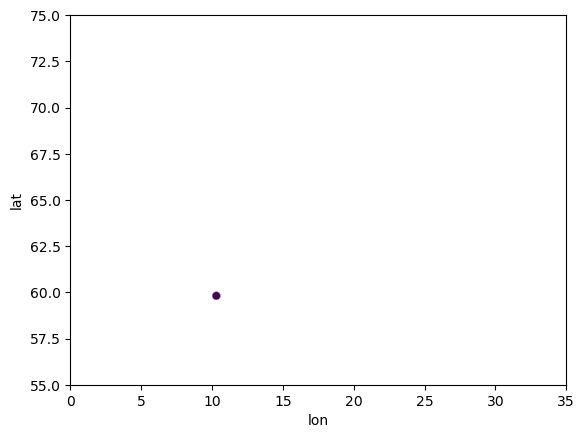

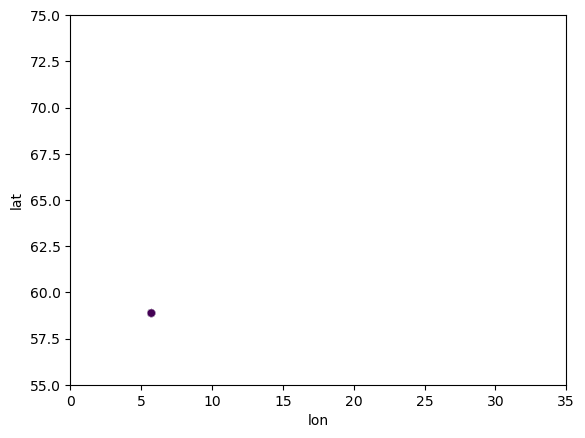

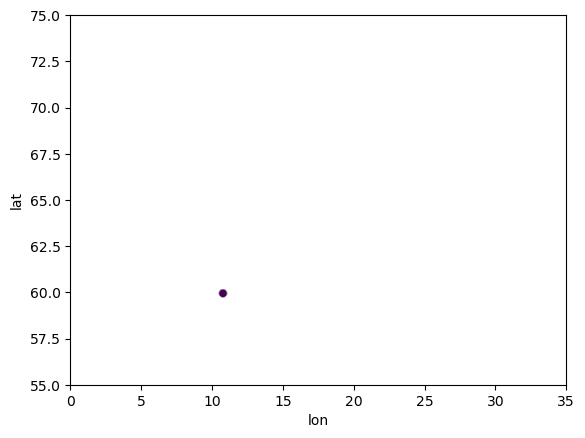

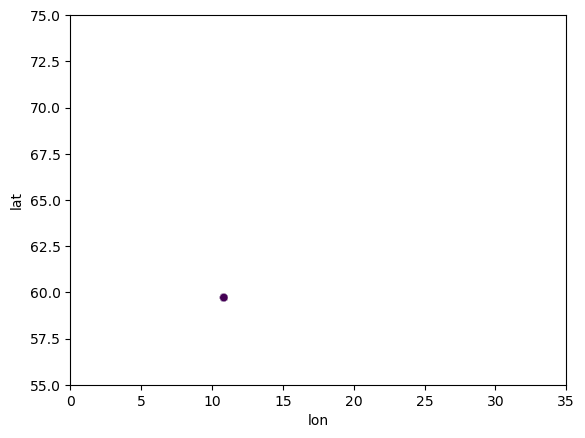

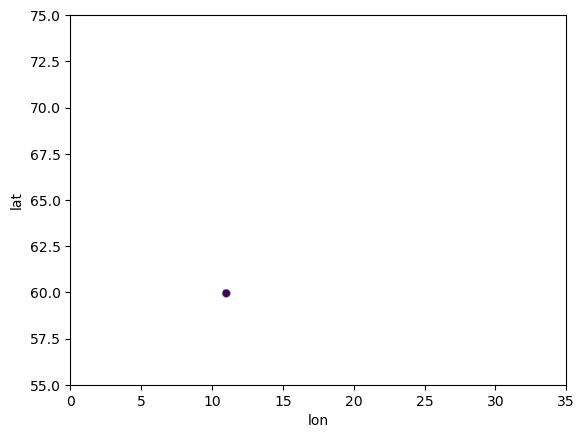

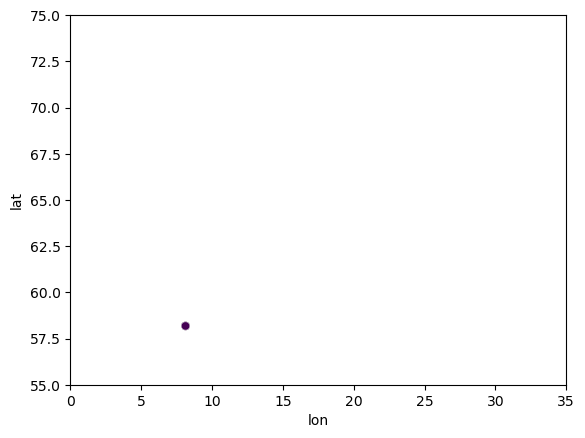

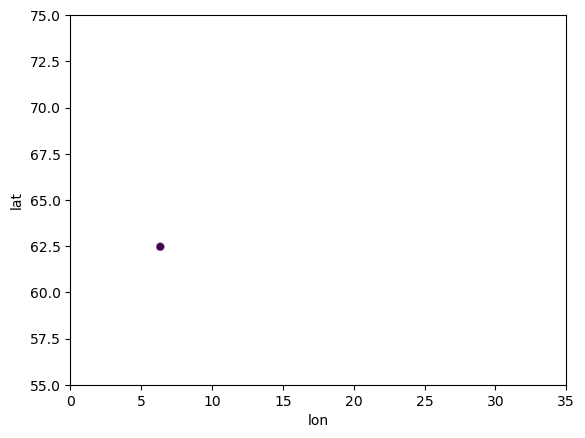

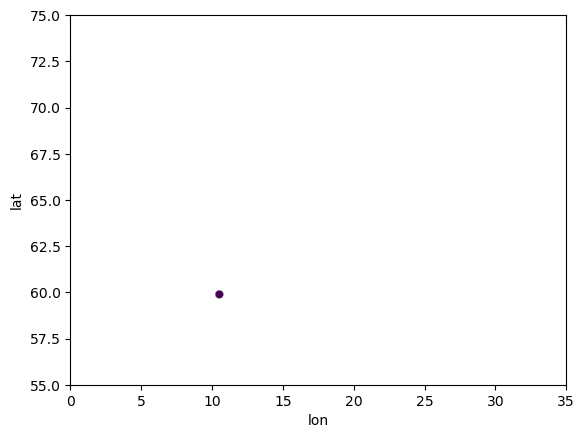

0.001 100 23


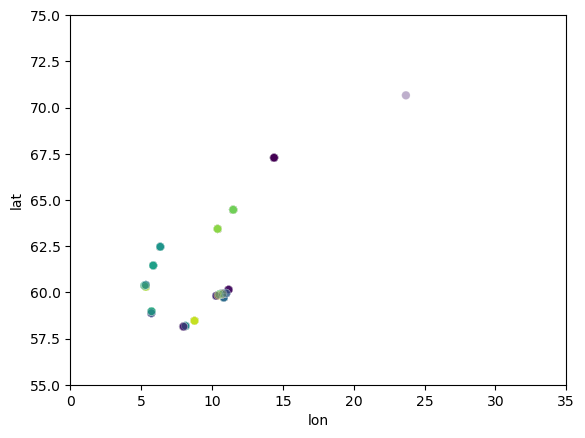

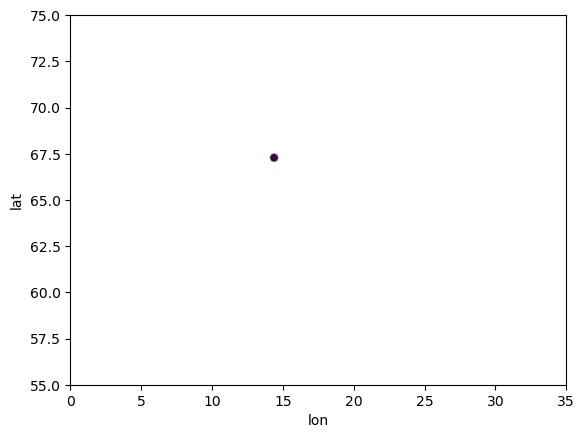

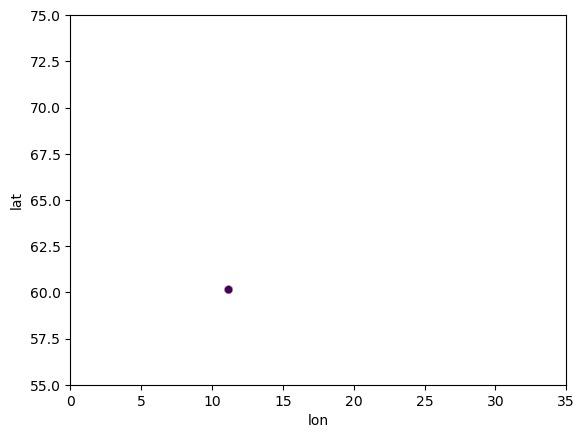

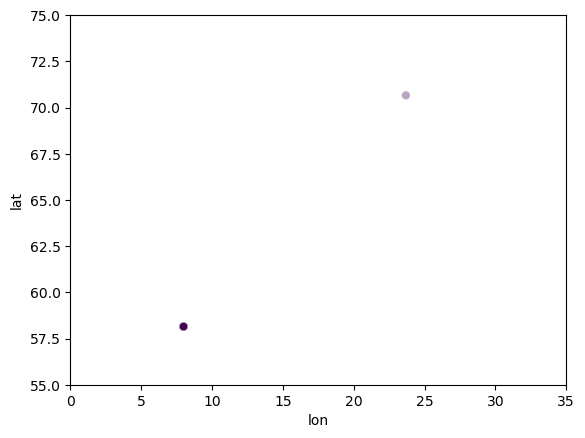

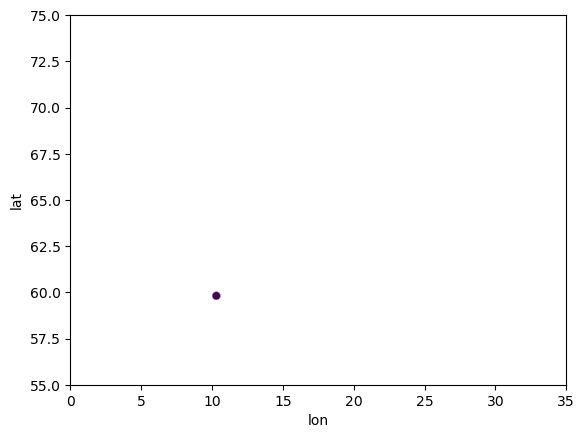

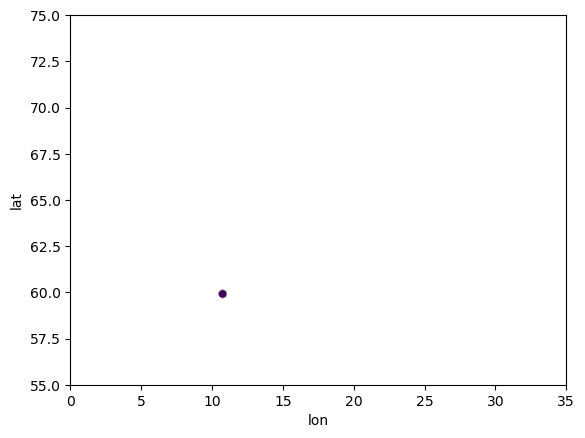

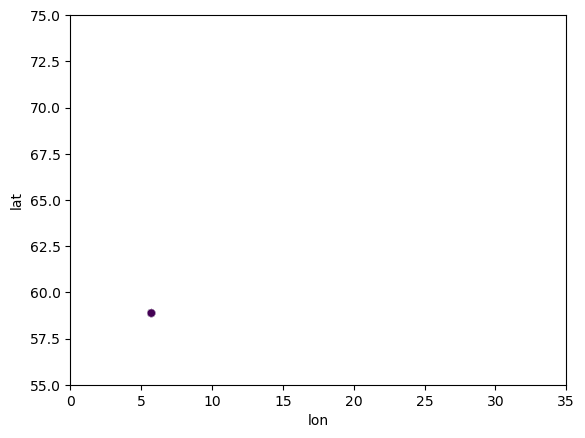

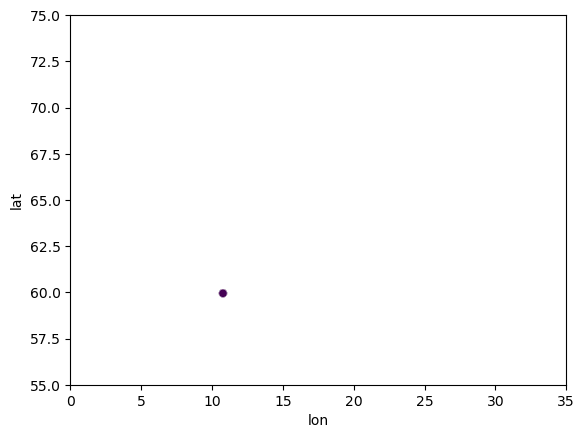

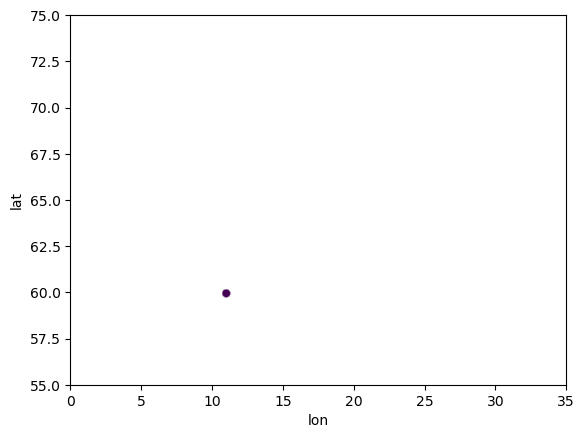

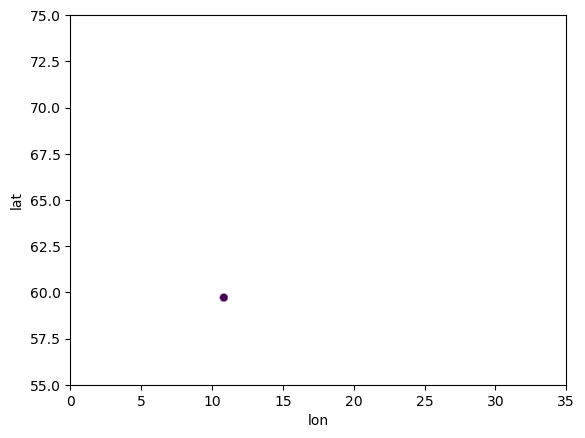

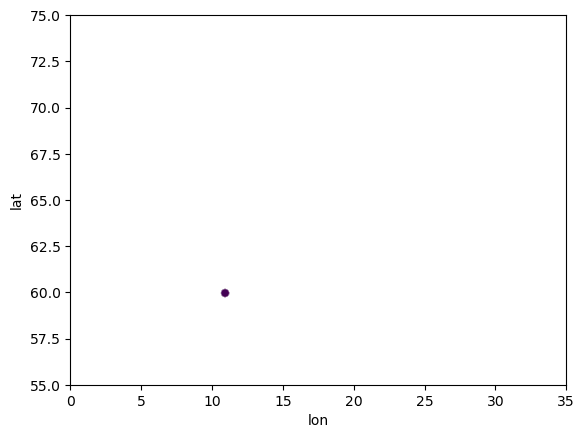

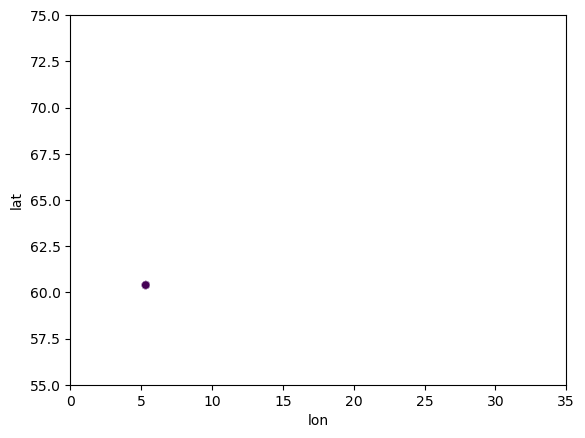

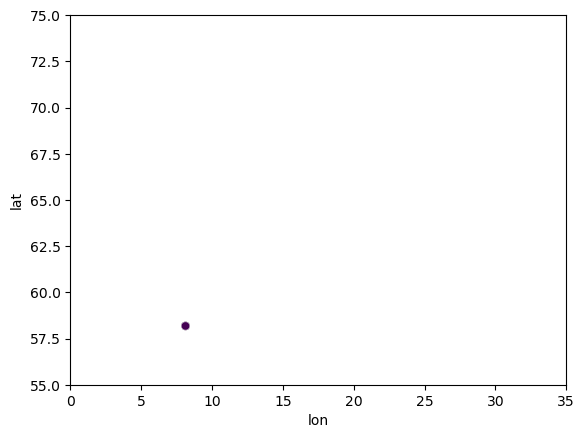

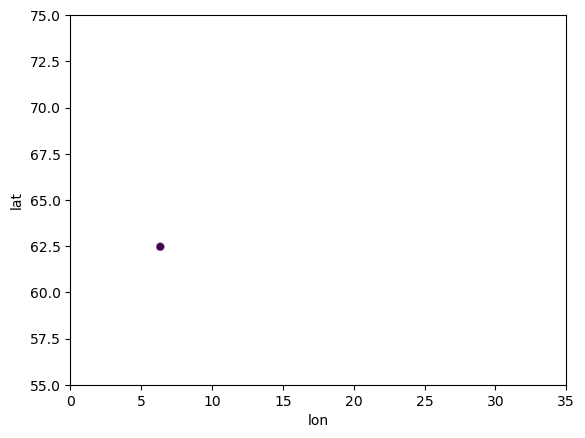

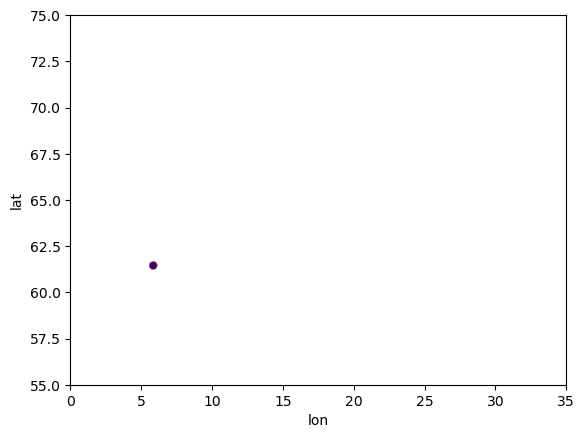

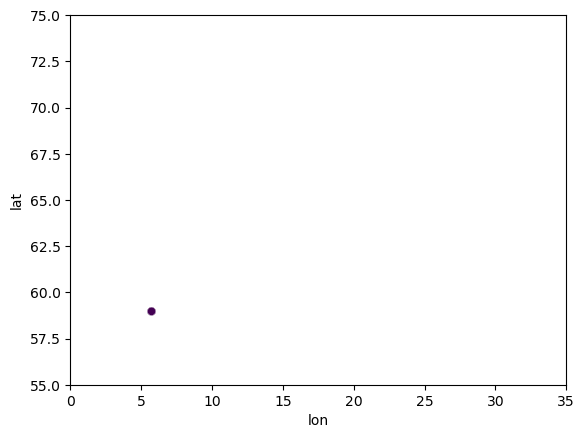

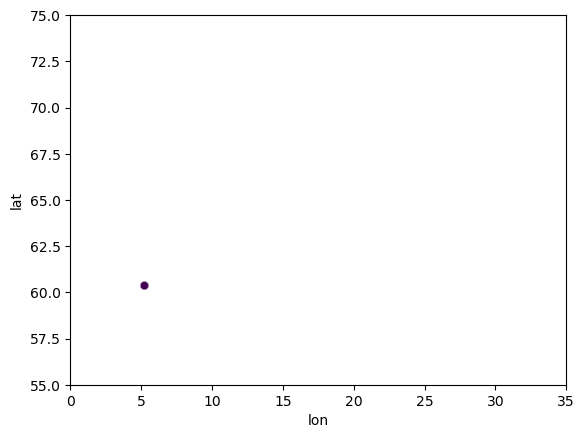

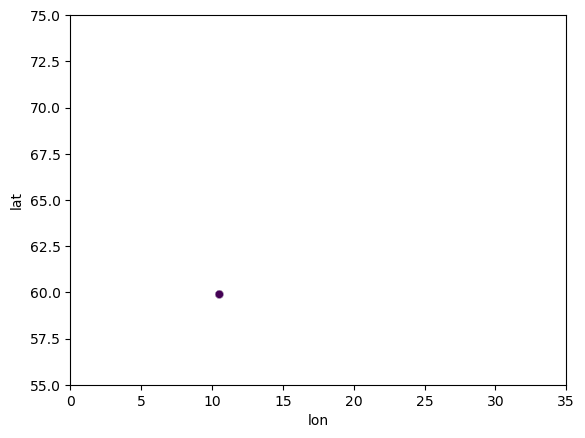

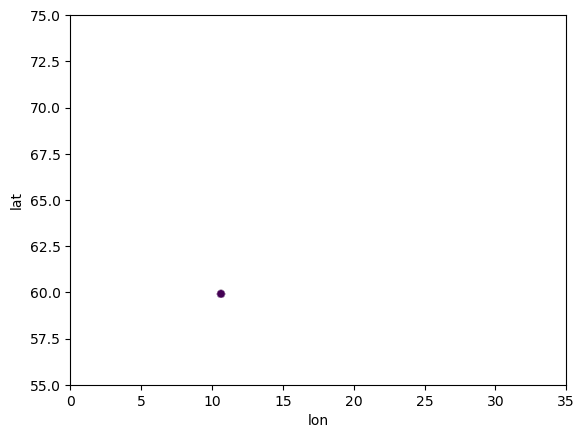

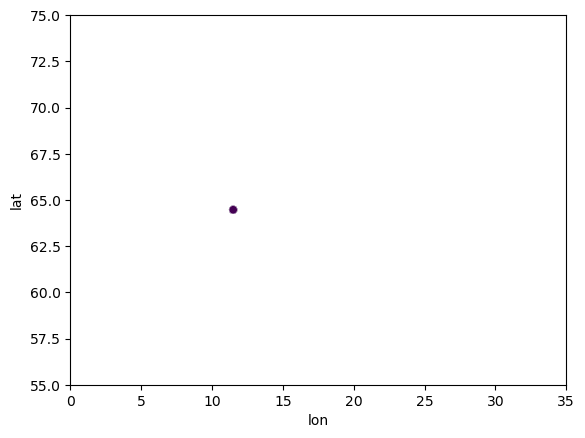

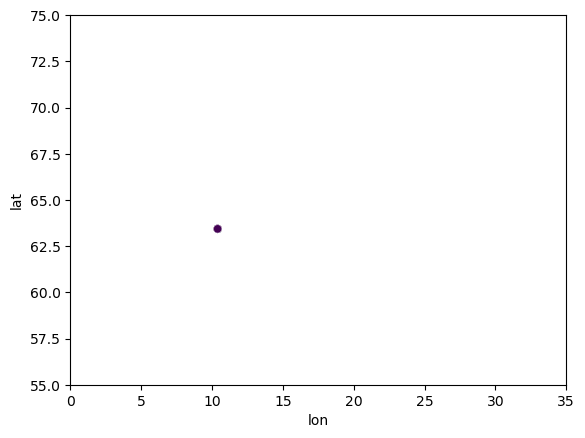

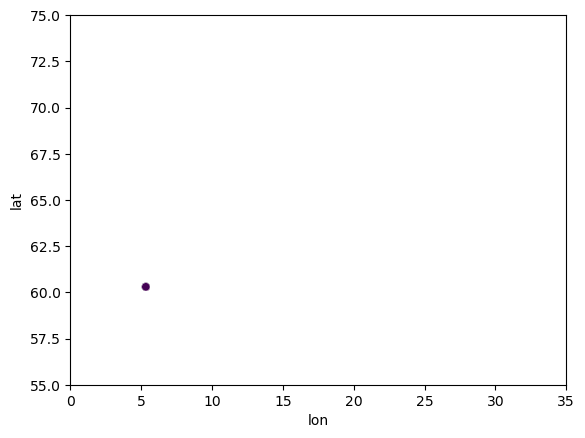

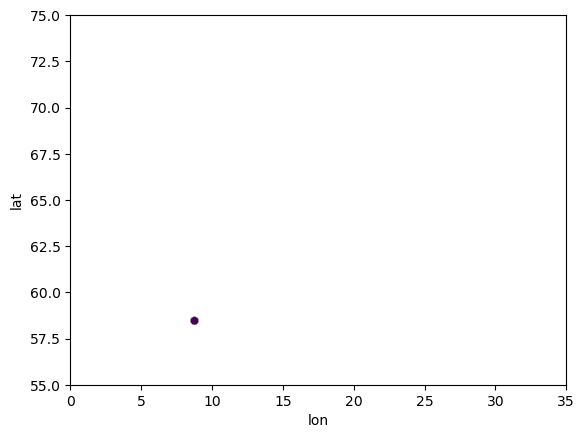

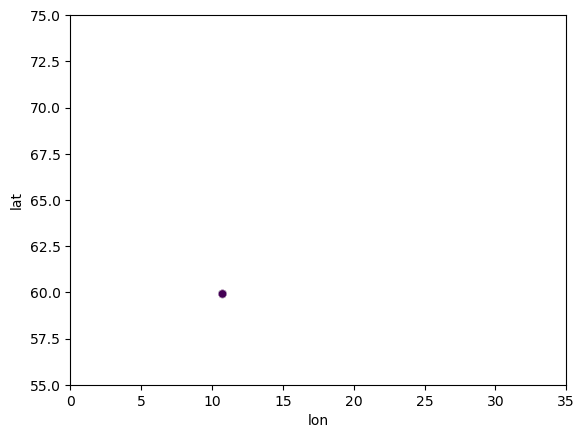

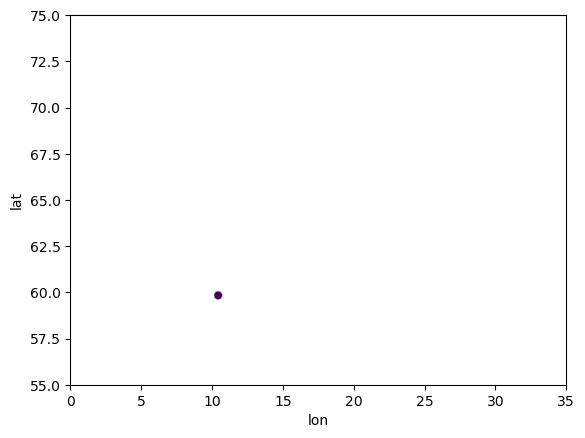

0.001 125 12


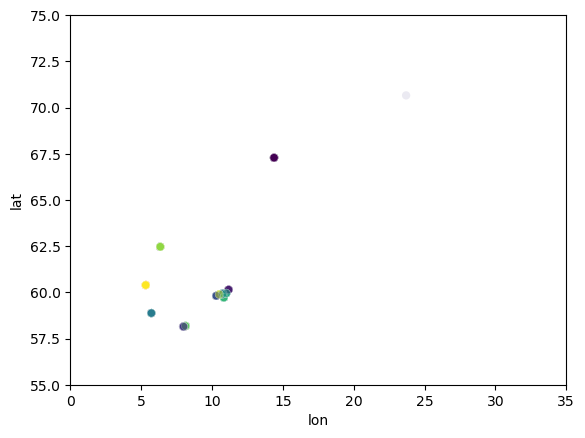

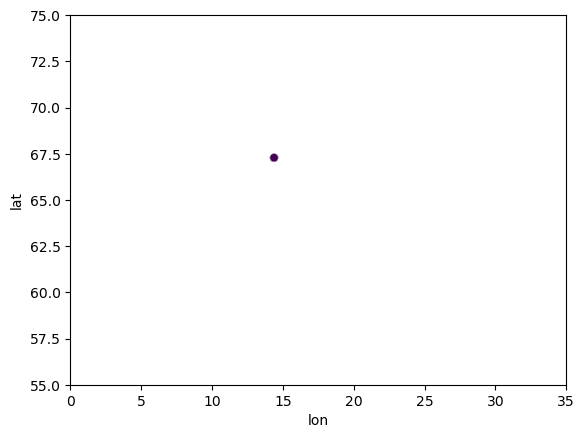

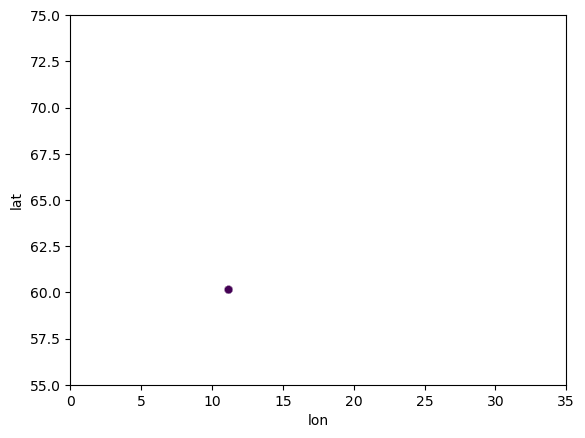

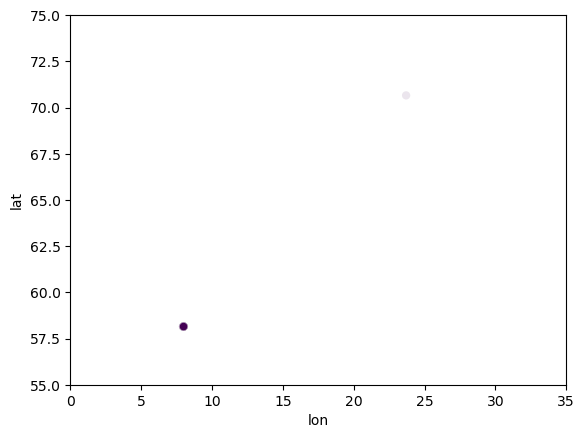

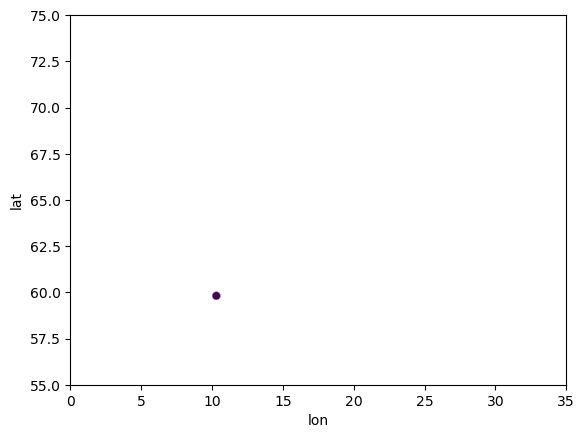

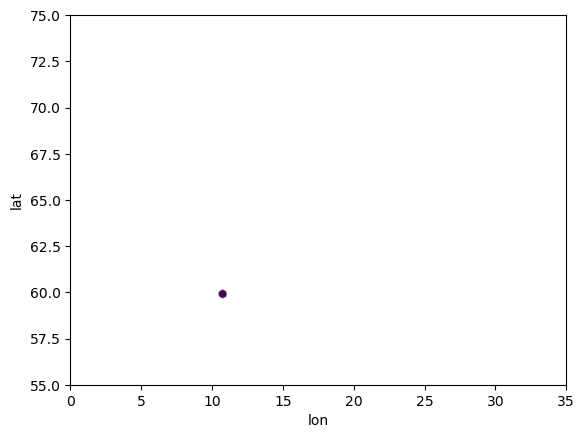

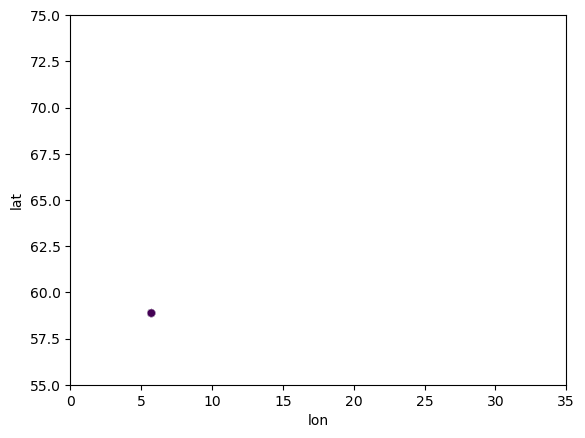

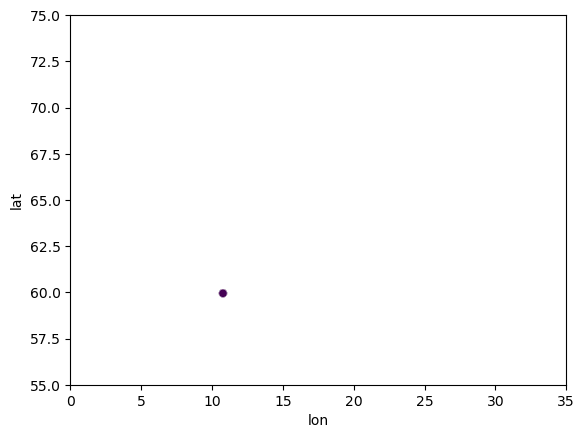

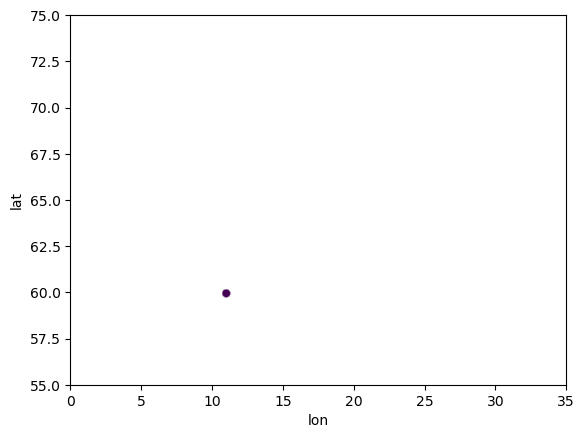

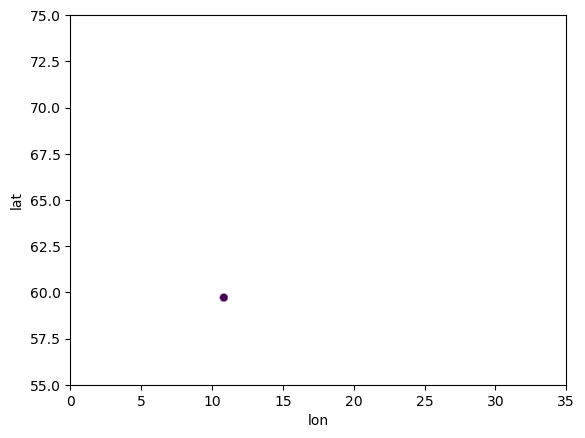

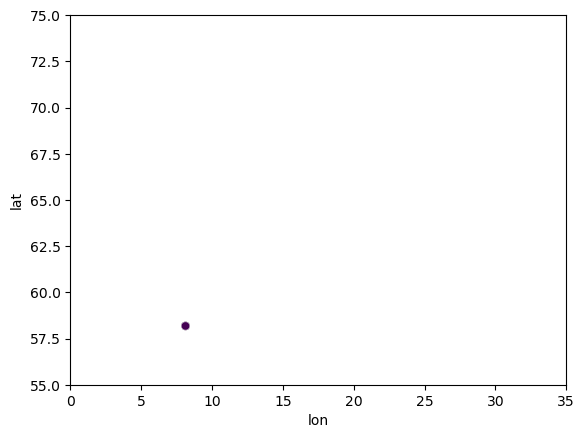

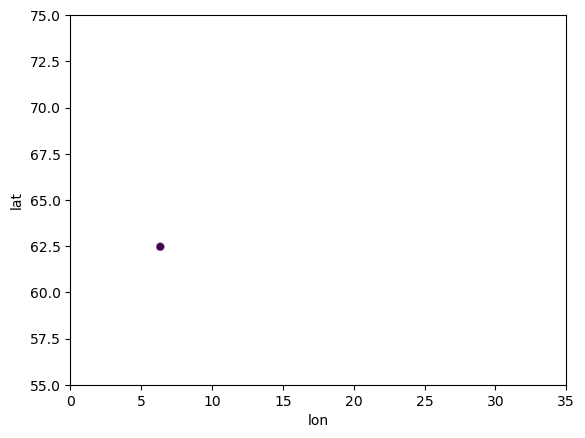

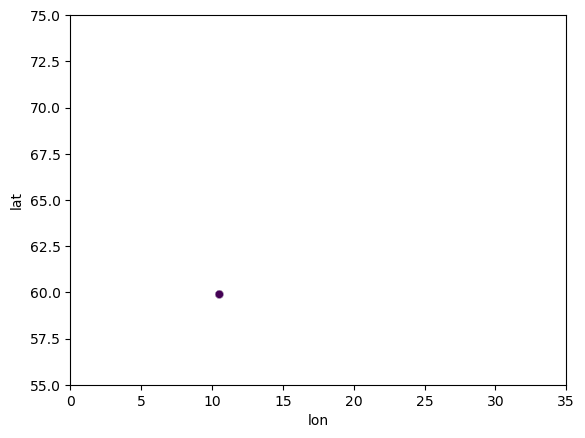

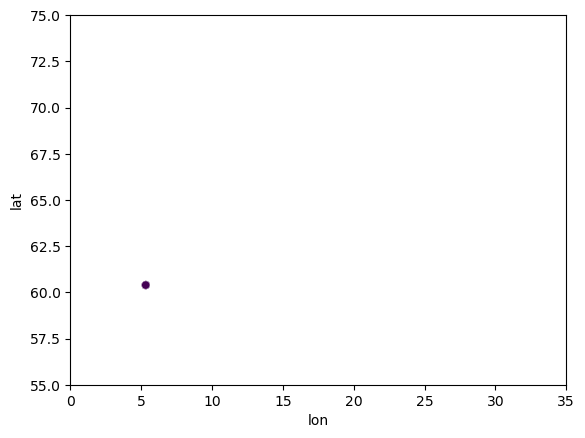

0.001 150 6


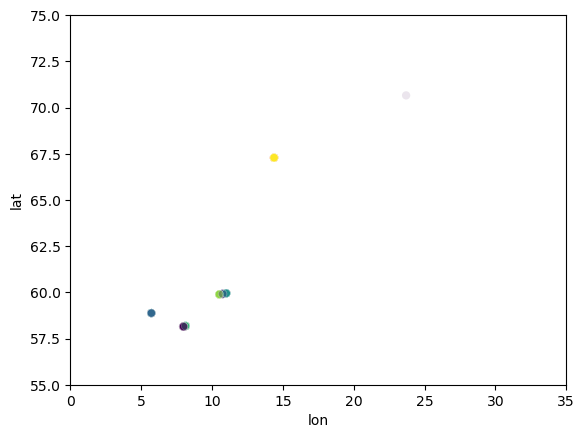

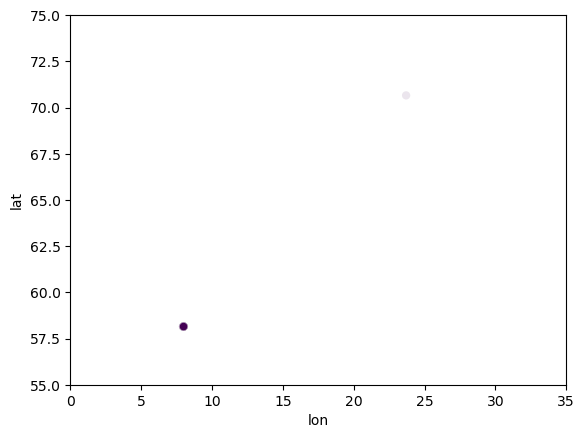

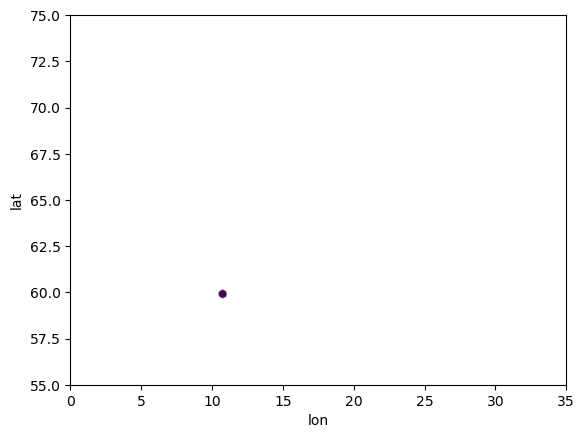

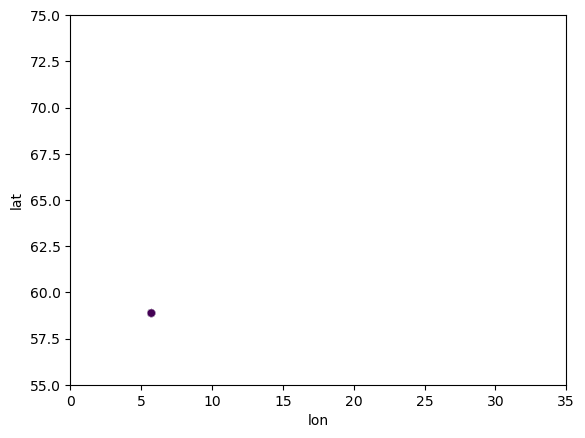

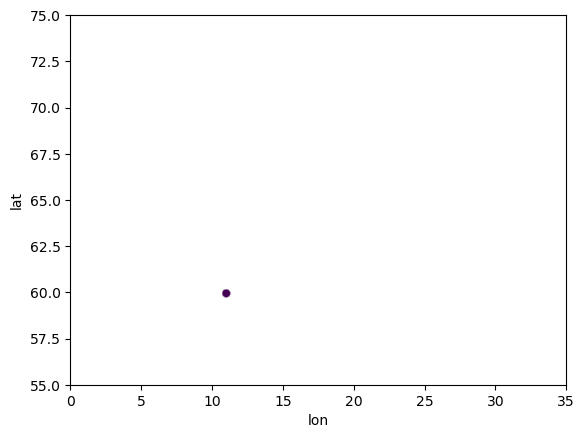

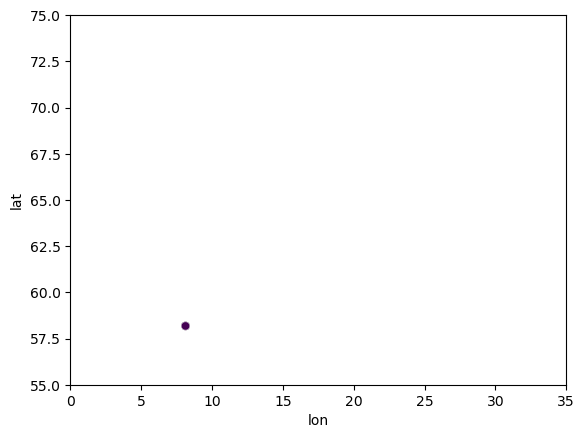

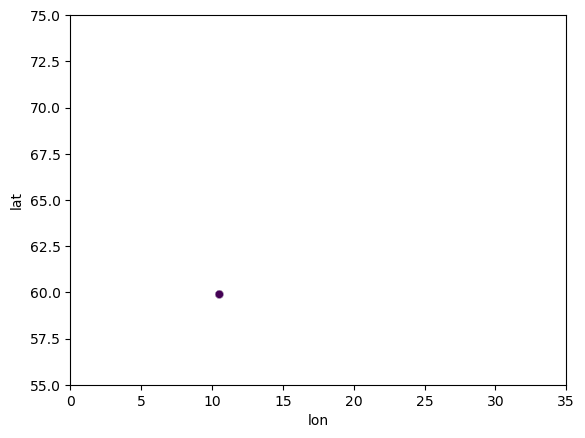

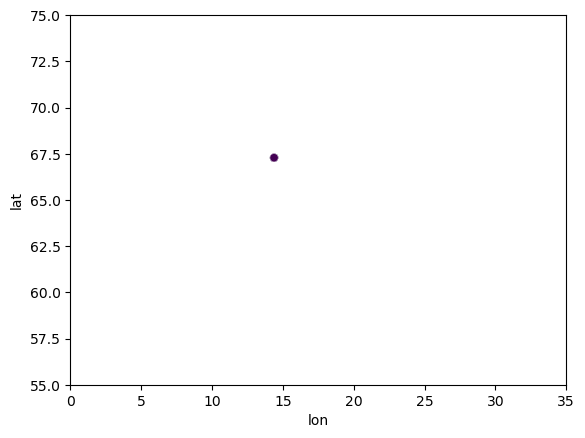

0.002 150 19
0.002 175 15
0.002 200 9
0.002 225 6


In [10]:
for g in good:
    geo_df['cluster'] = g[0]

    print(g[1], g[2], g[0].max())
    if g[1] > 0.001:
        continue

    df = geo_df[geo_df['cluster'] != -1]
    sns.scatterplot(data=df, x='lon', y="lat", c=df['cluster'], alpha=0.1)
    plt.xlim(0,35)
    plt.ylim(55,75)
    plt.show()

    for c in range(g[0].max()+1):
        df = geo_df[geo_df['cluster'] == c]
        # sns.scatterplot(data=df, x='lon', y="lat",  palette='red', alpha=0.1)
        sns.scatterplot(data=df, x='lon', y="lat", c=df['cluster'], alpha=0.1)
        plt.xlim(0,35)
        plt.ylim(55,75)
        plt.show()

In [116]:
labels = good[8][0]
good[8][1:3]

(0.001, 100)

In [117]:
geo_df['cluster'] = labels
geo_df['cluster'].value_counts()

-1     46203
 2       442
 7       245
 10      244
 14      233
 4       214
 0       200
 11      183
 5       178
 16      168
 1       151
 3       147
 6       139
 8       138
 21      127
 12      126
 20      124
 9       119
 22      110
 13      109
 18      108
 15      104
 19      104
 17      103
 23      101
Name: cluster, dtype: int64

In [118]:
geo_df

,lat,lon,store_id,cluster
0,59.743104,10.204928,983540538-974187930-44774,-1
1,59.913759,10.734031,987074191-973117734-44755,-1
2,60.164751,10.254656,984890265-981157303-64491,-1
3,67.283669,14.379796,914057442-992924179-126912,0
4,63.358068,10.374832,913018583-913063538-668469,-1
...,...,...,...,...
8572,59.259575,5.325813,917323003-917383529-844309,-1
8573,58.976219,5.721546,917353379-917411824-845904,-1
8574,59.928330,11.163202,917072302-917089248-833647,-1
8575,60.445790,5.161587,916960557-916993161-829908,-1


In [119]:
import numpy as np

full_df_train = pd.merge(stores_train, geo_df[['store_id', 'cluster']], on='store_id', how='left')
full_df_val = pd.merge(stores_val, geo_df[['store_id', 'cluster']], on='store_id', how='left')
full_df_train['count'] = 1
mapping_df = full_df_train.groupby('cluster').agg({'lat':'mean', 'lon':'mean', 'count':'sum', 'revenue':'mean', }).sort_values('revenue').reset_index()
mapping_df['new_cluster'] = mapping_df.index
# pd.merge(full_df, mapping_df, on='cluster')
full_new_df = pd.merge(full_df_val, mapping_df[['cluster', 'new_cluster']], on='cluster')
full_new_df.groupby('new_cluster').mean()

,year,grunnkrets_id,lat,lon,revenue,cluster
new_cluster,,,,,,
0,2016.0,3.013917e+06,59.962146,10.924524,4.195000,9.0
1,2016.0,9.065102e+06,58.460302,8.765509,5.680750,21.0
2,2016.0,6.260802e+06,59.811292,10.305843,4.409400,3.0
3,2016.0,1.001079e+07,58.146464,7.991759,10.081133,2.0
4,2016.0,2.350205e+06,60.142547,11.171911,6.106000,1.0
5,2016.0,1.804010e+07,67.283866,14.379629,3.475500,0.0
6,2016.0,1.201192e+07,60.363221,5.233627,6.268000,15.0
7,2016.0,1.102020e+07,58.876265,5.721772,7.376000,5.0
8,2016.0,1.601120e+07,63.432887,10.397168,7.325500,19.0


### Korresponderende byer
0 Oslo 
1 Arendal
2 Lier
3 Kristiansand
4 Jessheim
5 Bodø
6 Bergen
7 Sandnes
8 Trondheim
9 Bærum
10 Ski
11 Bergen 
12 Asker 
13 Namsos
14 Hele landet
15 Bergen
16 Oslo 
17 Oslo
18 Stavanger
19 Sandvika
20 Førde
21 Strømmen
22 Ålesund
23 Kristiansand
24 Oslo



In [120]:
full_new_df['log_revenue'] = np.log1p(full_new_df['revenue'])
full_new_df[['revenue', 'log_revenue', 'new_cluster']].corr()

,revenue,log_revenue,new_cluster
revenue,1.000000,0.788272,0.007396
log_revenue,0.788272,1.000000,-0.018658
new_cluster,0.007396,-0.018658,1.000000


In [125]:
from clustering import create_cluster_csv, add_clusters
create_cluster_csv()
add_clusters(stores_test)

/home/halvorlinder/NTNU/Machine_Learning/TDT4173/clustering.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  geo_df['cluster'] = labels


,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,cluster
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN,-1
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN,-1
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter,9
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN,-1
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,2016,GULATING HAUGESUND,2.8.11.2,Beer and soda shop,11490601,BRÅTAVEGEN 30,59.259575,5.325813,GULATING GRUPPEN,NaN,-1
8573,917353379-917411824-845904,2016,STAVANGER BEER AS,2.8.11.2,Beer and soda shop,11030901,SANDVIGÅ 7,58.976219,5.721546,NaN,NaN,-1
8574,917072302-917089248-833647,2016,GULATING ØLUTSALG OG PUB,2.8.11.2,Beer and soda shop,2270103,GARDERBAKKEN 6,59.928330,11.163202,GULATING GRUPPEN,NaN,-1
8575,916960557-916993161-829908,2016,VI BRYGGER BUTIKKDRIFT AS,2.8.11.2,Beer and soda shop,12470701,RAVNANGERVEGEN,60.445790,5.161587,NaN,NaN,-1
